# lassoCV

This notebook demonstrates how to conduct Lasso with stratified K fold cross validation
on the Calling Cards data.  

## Pulling the data

The calling cards data should now strictly be taken from data source 'brent_nf_cc'. All
of the Mitra data has been reprocessed through the nf-core/callingcards:1.0.0 pipeline.  

Where there are multiple replicates, they have been aggregated. The `deduplicate`
parameter to `PromoterSetSigAPI()` selects aggregated data where it exists. Where
there is a single passing replicate, that replicate is used.

## Setup

As usual, import the `yeastdnnexplorer` interface functions

In [1]:
# configure the logger to print to console
import logging

import pandas as pd
from sklearn.linear_model import LassoCV

from tfbpmodeling.lasso_modeling import (
    ModelingInputData,
    BootstrappedModelingInputData,
    stratification_classification,
    bootstrap_stratified_cv_modeling)

# from yeastdnnexplorer.ml_models.GeneralizedLogisticModel import (
#     GeneralizedLogisticEstimatorL1CV,
# )

logging.basicConfig(level=logging.DEBUG)

In [ ]:
#response_df = pd.read_csv("/home/chase/htcf_ref/data/yeast_database_modeling/pull_data_20241231/response_frames/CBF1.csv")
response_df = pd.read_csv("/home/chase/htcf_ref/data/yeast_database_modeling/pull_data_20250325/response_frames/CBF1.csv")

#predictors_df = pd.read_csv("/home/chase/htcf_ref/data/yeast_database_modeling/pull_data_20241231/predictors_brent_nf_cc_mcisaac_oe_20241231.csv")
predictors_df = pd.read_csv("/home/chase/htcf_ref/data/yeast_database_modeling/pull_data_20250325/predictors_normalized.csv")

In [ ]:
input_data = ModelingInputData(
    response_df=response_df,
    predictors_df=predictors_df,
    perturbed_tf="CBF1",
    top_n = 600,
)

#feature_blacklist=# list('URA3'),

input_data.top_n_masked = False

INFO:main:Response column names: Index(['CBF1'], dtype='object')
INFO:main:Common features between response and predictors: 6065. Subsetting and reordering both dataframes.
INFO:main:Number of blacklisted features: 1
INFO:main:Selected 600 top features based on descending ranking of predictors_df['CBF1'].
INFO:main:Top-n feature masking enabled.
INFO:main:Top-n feature masking disabled.


In [6]:
predictor_variables = input_data.predictors_df.columns.drop(
        input_data.perturbed_tf
    )

interaction_terms = [
        f"{input_data.perturbed_tf}:{var}" for var in predictor_variables if var != "red_median"
    ]

# Construct the formula as a single expression (no intercept)
formula = f"{input_data.perturbed_tf} + {' + '.join(interaction_terms)}"
# #formula = f"{input_data.perturbed_tf}"

# # add the row_max term to the formula
# # formula += f" + row_max"

# # add perturbed_tf ** 2
# formula += f" + I({input_data.perturbed_tf} ** 2)"
# formula += " + red_median"

print(formula)

#len(interaction_terms) == len(predictor_variables)

CBF1 + CBF1:DOT6 + CBF1:MTH1 + CBF1:FZF1 + CBF1:PIP2 + CBF1:HAA1 + CBF1:SFL1 + CBF1:XBP1 + CBF1:WTM1 + CBF1:SWI4 + CBF1:SWI5 + CBF1:SWI6 + CBF1:ACE2 + CBF1:MIG1 + CBF1:STB5 + CBF1:YAP6 + CBF1:ACA1 + CBF1:LYS14 + CBF1:RGM1 + CBF1:ARG80 + CBF1:SEF1 + CBF1:PUT3 + CBF1:DIG1 + CBF1:GCR2 + CBF1:SFP1 + CBF1:BAS1 + CBF1:GAT4 + CBF1:MIG2 + CBF1:MAL13 + CBF1:IME4 + CBF1:SPT2 + CBF1:GAT2 + CBF1:ARG81 + CBF1:CUP9 + CBF1:MSN1 + CBF1:PGD1 + CBF1:MED2 + CBF1:OPI1 + CBF1:STP1 + CBF1:PHO2 + CBF1:STP2 + CBF1:FKH2 + CBF1:ASH1 + CBF1:CST6 + CBF1:PHO4 + CBF1:TEC1 + CBF1:RDR1 + CBF1:DAT1 + CBF1:PHD1 + CBF1:CYC8 + CBF1:ADA2 + CBF1:IXR1 + CBF1:PDR1 + CBF1:VHR1 + CBF1:YHP1 + CBF1:HAP5 + CBF1:CHA4 + CBF1:RFX1 + CBF1:MBP1 + CBF1:TEA1 + CBF1:SKO1 + CBF1:ZAP1 + CBF1:HAP2 + CBF1:GZF3 + CBF1:MET31 + CBF1:ARO80 + CBF1:RDS2 + CBF1:MET28 + CBF1:INO4 + CBF1:RPH1 + CBF1:INO2 + CBF1:SKN7 + CBF1:HAL9 + CBF1:HAP3 + CBF1:RPD3 + CBF1:HFI1 + CBF1:TYE7 + CBF1:SOK2 + CBF1:RLM1 + CBF1:PPR1 + CBF1:GCN5 + CBF1:FKH1 + CBF1:STP3 + CB

In [ ]:

bootstrapped_data_all = BootstrappedModelingInputData(
    response_df=input_data.response_df,
    model_df = input_data.get_modeling_data(formula, drop_intercept=True),
    n_bootstraps=1,
)


INFO:main:Sample weights normalization: True


In [8]:
# bootstrapped_data_all.model_df.shape

bootstrapped_data_all.response_df.index.equals(input_data.response_df.index)

True

In [9]:
input_data.predictors_df[input_data.perturbed_tf].index.equals(bootstrapped_data_all.response_df.index)

True

In [10]:

classes = stratification_classification(input_data.predictors_df[input_data.perturbed_tf].squeeze(), input_data.response_df.squeeze())


In [10]:

# NOTE: fit_intercept is set to `true`
estimator = LassoCV(
    fit_intercept=True,
    max_iter=10000,
    selection="random",
    random_state=42,
    n_jobs=4)

sigmoid_estimator = GeneralizedLogisticEstimatorL1CV(
    n_jobs=4,
    cv=4,
    n_alphas=100,
    verbose=True,
    epochs=10000,
    early_stopping=True,
    tol=1e-8,
    batch_size=128,
)

perturbed_tf_series = input_data.predictors_df[
        input_data.perturbed_tf
    ]


In [ ]:

all_data_results = bootstrap_stratified_cv_modeling(
        bootstrapped_data_all,
        perturbed_tf_series,
        ci_percentiles=[98.0],
        use_sample_weight_in_cv=True,
        estimator=sigmoid_estimator,
    )


In [10]:
all_data_results.extract_significant_coefficients()

NameError: name 'all_data_results' is not defined

In [ ]:
all_data_results.ci_dict.keys()

dict_keys(['98.0'])

In [ ]:
all_data_sig_coefs = all_data_results.extract_significant_coefficients(
    ci_level="98.0"
)

all_data_sig_coefs

{'CIN5': (0.006338114840928867, 0.006338114840928867),
 'CIN5:ARO80': (-0.0023817639588242542, -0.0023817639588242542),
 'CIN5:SKN7': (-0.008292809977606235, -0.008292809977606235),
 'CIN5:RTG1': (-0.001555869829784138, -0.001555869829784138),
 'CIN5:TYE7': (-0.003081494643980482, -0.003081494643980482),
 'CIN5:STP2': (-0.0025101318556082896, -0.0025101318556082896),
 'CIN5:YHP1': (-0.004618754348804078, -0.004618754348804078),
 'CIN5:SOK2': (0.0011969313986244258, 0.0011969313986244258),
 'CIN5:DIG1': (0.0027566022012522912, 0.0027566022012522912),
 'CIN5:UME1': (0.00018707053219164932, 0.00018707053219164932),
 'CIN5:MET28': (0.002462910061347813, 0.002462910061347813),
 'CIN5:GAL80': (-0.004690045284432514, -0.004690045284432514),
 'CIN5:SFP1': (0.0003702489059843471, 0.0003702489059843471),
 'CIN5:HAP4': (-0.0004947129801821189, -0.0004947129801821189),
 'CIN5:ACE2': (-0.005111648160892968, -0.005111648160892968),
 'CIN5:AFT1': (0.0019988271365223914, 0.0019988271365223914),
 'CIN5

In [11]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, groups, ax, n_splits, lw=10, max_points=None):
    """
    Visualize cross-validation train/test splits and class/group membership.

    Parameters
    ----------
    cv : cross-validation object (e.g., StratifiedKFold)
    X : array-like, shape (n_samples, n_features)
        Feature matrix.
    y : array-like, shape (n_samples,)
        Class labels (e.g., response).
    groups : array-like, shape (n_samples,)
        Group labels used in splitting (e.g., stratification).
    ax : matplotlib Axes
        Where to draw the plot.
    n_splits : int
        Number of CV folds.
    lw : int
        Line width for the plot.
    max_points : int or None
        If set, limits the number of samples shown (for faster plotting).
    """
    if max_points is not None:
        X = X[:max_points]
        y = y[:max_points]
        groups = groups[:max_points]

    for ii, (train_idx, test_idx) in enumerate(cv.split(X, y=groups)):
        indices = np.full(len(X), np.nan)
        indices[test_idx] = 1
        indices[train_idx] = 0
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    ax.scatter(
        range(len(X)), [n_splits + 0.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )
    ax.scatter(
        range(len(X)), [n_splits + 1.5] * len(X), c=groups, marker="_", lw=lw, cmap=cmap_data
    )

    yticklabels = [f"Fold {i}" for i in range(n_splits)] + ["response", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title(type(cv).__name__, fontsize=15)


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/chase/code/yeastdnnexplorer/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/chase/code/yeastdnnexplorer/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/chase/code/yeastdnnexplorer/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='De

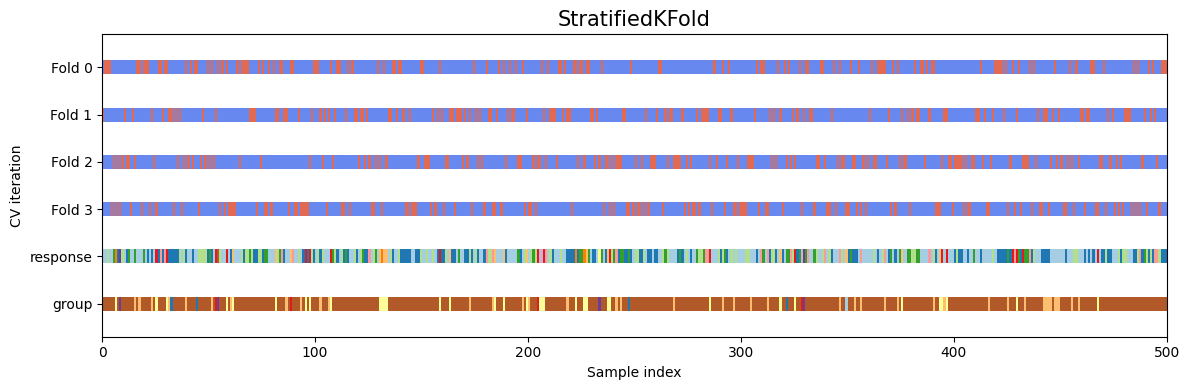

In [12]:
from sklearn.model_selection import StratifiedKFold
from matplotlib.cm import ScalarMappable

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

classes = stratification_classification(
    input_data.predictors_df[input_data.perturbed_tf].squeeze(),
    input_data.response_df.squeeze(),
    bin_by_binding_only=True,
)

fig, ax = plt.subplots(figsize=(12, 4))
plot_cv_indices(
    skf,
    X=bootstrapped_data_all.model_df,
    y=bootstrapped_data_all.response_df.squeeze(),
    groups=classes,
    ax=ax,
    n_splits=4,
    max_points=500  # or None if you want all
)
plt.tight_layout()
sm = ScalarMappable(cmap=cmap_data)


In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

folds = list(skf.split(
    bootstrapped_data_all.model_df,
    classes,
))


/home/chase/code/yeastdnnexplorer/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [26]:
import yeastdnnexplorer
from yeastdnnexplorer.ml_models import SigmoidModel 
import importlib
importlib.reload(yeastdnnexplorer.ml_models.SigmoidModel)

sigmoid_estimator = SigmoidModel.SigmoidModel(
    cv=folds,
    alphas=list(np.linspace(0.1, 100, 10))
)

sigmoid_estimator.fit(bootstrapped_data_all.model_df,
    bootstrapped_data_all.response_df.squeeze(),
)

INFO:yeastdnnexplorer.ml_models.SigmoidModel:warm start is True. Creating linear model coef sampler


SigmoidModel(alphas=[0.1, 11.200000000000001, 22.300000000000004,
                     33.400000000000006, 44.50000000000001, 55.60000000000001,
                     66.7, 77.80000000000001, 88.9, 100.0],
             cv=[(array([   0,    1,    2, ..., 6059, 6061, 6062]),
                  array([   3,   15,   19, ..., 6055, 6060, 6063])),
                 (array([   0,    2,    3, ..., 6061, 6062, 6063]),
                  array([   1,    4,    8, ..., 6051, 6052, 6054])),
                 (array([   0,    1,    2, ..., 6059, 6060, 6063]),
                  array([   7,   14,   17, ..., 6058, 6061, 6062])),
                 (array([   1,    3,    4, ..., 6061, 6062, 6063]),
                  array([   0,    2,    5, ..., 6048, 6050, 6059]))])

DEBUG:matplotlib.ticker:vmin 0.0707945784384138 vmax 141.2537544622754
DEBUG:matplotlib.ticker:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
DEBUG:matplotlib.ticker:vmin 0.0707945784384138 vmax 141.2537544622754
DEBUG:matplotlib.ticker:ticklocs array([2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04])
DEBUG:matplotlib.ticker:vmin 0.0707945784384138 vmax 141.2537544622754
DEBUG:matplotlib.ticker:ticklocs array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 

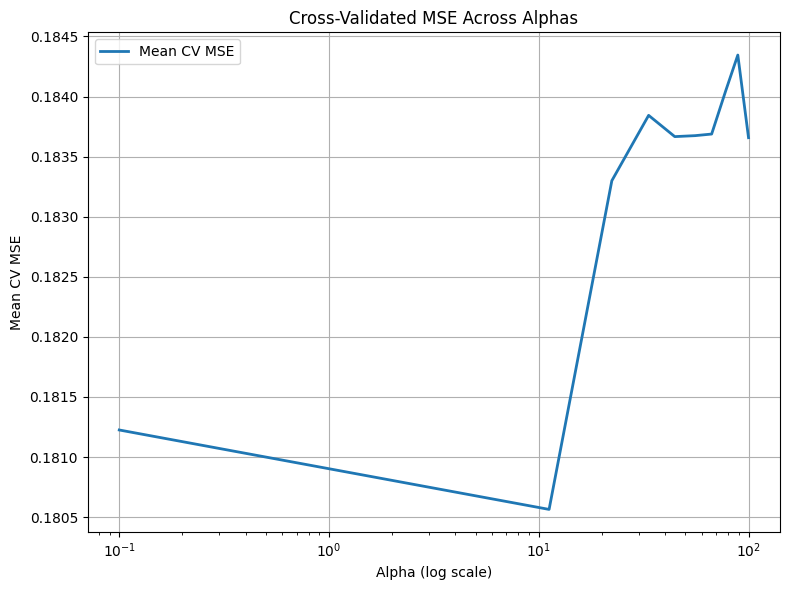

In [29]:
mean_scores = np.mean(sigmoid_estimator.mse_path_, axis=1)

# Optional: provide alphas_ if you have them
alphas = sigmoid_estimator.alphas_

plt.figure(figsize=(8, 6))
plt.plot(alphas, mean_scores, label="Mean CV MSE", lw=2)
plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean CV MSE")
plt.title("Cross-Validated MSE Across Alphas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# gle_l1 = .GeneralizedLogisticEstimatorL1CV(
#     n_jobs=4,
#     cv=folds,
#     n_alphas=100,
#     verbose=True,
#     epochs=300,
#     early_stopping=True,
#     tol=1e-4,
#     batch_size=128,
# )



In [ ]:
# import time

# start = time.time()
# gle_l1.fit(bootstrapped_data_all.model_df, bootstrapped_data_all.response_df.squeeze(), optimizer_type="adam")
# print(f"Fit time: {time.time() - start:.2f}s")

INFO:main:Epoch 0 - Loss: 0.1839
INFO:main:Epoch 100 - Loss: 0.1676
INFO:main:Early stopping at epoch 103, loss improvement 0.000050 < tol=0.0001


Fit time: 523.44s


INFO:main:Epoch 0 - Loss: 0.1894
INFO:main:Epoch 0 - Loss: 0.1867
INFO:main:Epoch 0 - Loss: 0.1870
INFO:main:Epoch 0 - Loss: 0.1887


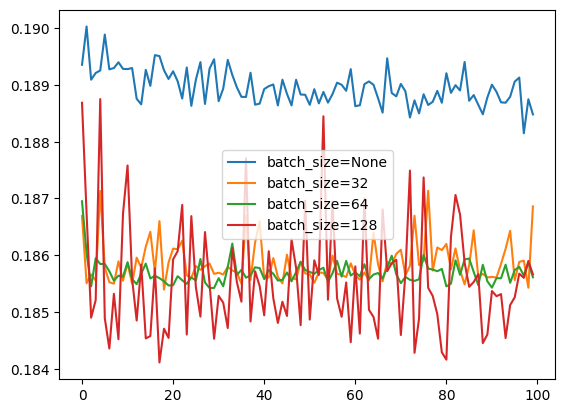

In [ ]:
# for batch_size in [None, 32, 64, 128]:
#     model = GeneralizedLogisticModel.GeneralizedLogisticEstimator(
#         alpha=0.01,
#         batch_size=batch_size,
#         epochs=100,
#         early_stopping=True,
#         verbose=True,
#     )
#     model.fit(bootstrapped_data_all.model_df, bootstrapped_data_all.response_df.squeeze())
#     plt.plot(model.loss_history, label=f"batch_size={batch_size}")
# plt.legend()

In [142]:
import os
import joblib

directory = "/home/chase/htcf_local/testing_sigmoid/test_output"
file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))]


In [39]:

import os
import joblib

results_dirs = {
    "incl_intercept": "/home/chase/htcf_local/testing_sigmoid/include_intercept_in_shrinkage",
    "excl_intercept": "/home/chase/htcf_local/testing_sigmoid/exclude_intercept_in_shrinkage",
    "old_sigmoid": "/home/chase/htcf_local/testing_sigmoid/exclude_intercept_with_old_sigmoid",
    "old_sigmoid_big_alpha": "/home/chase/htcf_local/testing_sigmoid/old_sigmoid_1_3_100",
    "old_sigmoid_01_100_alpha": "/home/chase/htcf_local/testing_sigmoid/old_sigmoid_01_100_100",
    "norm_predictors": "/home/chase/htcf_local/testing_sigmoid/norm_predictors_01_100_100"
}

results_paths = {
    key: [os.path.join(value, file) for file in os.listdir(value) if os.path.isfile(os.path.join(value, file))]
    for key, value in results_dirs.items()
}


In [40]:

def extract_results(suffix, paths, unlist=True):
    """
    :param suffix: eg "_lasso.pkl" or "_gle.pkl"
    """
    results = {
        os.path.basename(x).replace(suffix, ""): joblib.load(x)
        for x in paths
        if suffix in x
    }

    if unlist:
        results = {
            key: value for _, value_outer in results.items() for key, value in value_outer.items()
        }

    return results


In [41]:

results_objects = {
    # "sigmoid": {"incl_intercept": extract_results("_gle.pkl", results_paths["incl_intercept"]),
    #            "excl_intercept": extract_results("_gle.pkl", results_paths["excl_intercept"])},
    # "lasso": extract_results("_lasso.pkl", results_paths["incl_intercept"]),
    # "old_sigmoid": extract_results("_oldsigmoid.pkl", results_paths["old_sigmoid"], unlist=False),
    # "old_sigmoid_big_alpha": extract_results("_oldsigmoid.pkl", results_paths["old_sigmoid_big_alpha"], unlist=False),
    "norm_predictors": extract_results("_oldsigmoid.pkl", results_paths["norm_predictors"], unlist=False),}

In [ ]:
# results_objects["old_sigmoid_01_100_alpha"] = extract_results(
#     "_oldsigmoid.pkl", results_paths["old_sigmoid_01_100_alpha"], unlist=False
# )

In [ ]:
import yeastdnnexplorer
from yeastdnnexplorer.ml_models import GeneralizedLogisticModel
import importlib
importlib.reload(yeastdnnexplorer.ml_models.GeneralizedLogisticModel)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
import numpy as np

def evaluate_cv_at_fixed_alpha(model):
    """
    Evaluate training and test MSE of a fitted GeneralizedLogisticModel
    using cross-validation at the model's fixed alpha.

    Parameters
    ----------
    model : GeneralizedLogisticModel
        A previously fitted model with `.alpha_`, `.X`, and `.y` attributes set.

    Returns
    -------
    results : dict
        A dictionary containing mean and std of train/test MSE, and per-fold values.
    """
    if model.alpha_ is None:
        raise ValueError("Model must be fitted before evaluation. `alpha_` is not set.")
    if model.X is None or model.y is None:
        raise ValueError("Model is missing data. `X` or `y` is not set.")

    alpha = model.alpha_
    X = model.X
    y = model.y

    if isinstance(model.cv, int):
        folds = list(StratifiedKFold(n_splits=model.cv, shuffle=True, random_state=42).split(X, y))
    else:
        folds = model.cv

    train_mse_list = []
    test_mse_list = []

    def objective(w, X_local, y_local):
        linear_combination = np.dot(X_local, w[2:])
        left_asymptote = w[0]
        right_asymptote = w[1]
        pred = left_asymptote + (right_asymptote - left_asymptote) / (1 + np.exp(-linear_combination))
        residual = y_local - pred
        sse = np.sum(residual ** 2)
        penalty = alpha * np.sum(np.abs(w[2:]))
        return sse + penalty

    for train_idx, test_idx in folds:
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        w0 = np.zeros(X_train.shape[1] + 2)
        w0[1] = 1.0  # start right_asymptote at 1.0

        res = minimize(
            fun=objective,
            x0=w0,
            args=(X_train, y_train),
            method="L-BFGS-B",
            options={"maxiter": model.max_iter, "ftol": model.eps, "gtol": model.eps},
        )

        w_opt = res.x

        pred_train = w_opt[0] + (w_opt[1] - w_opt[0]) / (1 + np.exp(-np.dot(X_train, w_opt[2:])))
        pred_test = w_opt[0] + (w_opt[1] - w_opt[0]) / (1 + np.exp(-np.dot(X_test, w_opt[2:])))

        train_mse_list.append(mean_squared_error(y_train, pred_train))
        test_mse_list.append(mean_squared_error(y_test, pred_test))

    return {
        "train_mse_mean": np.mean(train_mse_list),
        "test_mse_mean": np.mean(test_mse_list),
        "train_mse_std": np.std(train_mse_list),
        "test_mse_std": np.std(test_mse_list),
        "per_fold_train_mse": train_mse_list,
        "per_fold_test_mse": test_mse_list,
    }


In [ ]:
old_sigmoid_final_model_results = {key: evaluate_cv_at_fixed_alpha(model) for key, model in results_objects.get("old_sigmoid").items()}

/tmp/ipykernel_11250/1654506884.py:46: RuntimeWarning: overflow encountered in exp
  pred = left_asymptote + (right_asymptote - left_asymptote) / (1 + np.exp(-linear_combination))
/tmp/ipykernel_11250/1654506884.py:69: RuntimeWarning: overflow encountered in exp
  pred_train = w_opt[0] + (w_opt[1] - w_opt[0]) / (1 + np.exp(-np.dot(X_train, w_opt[2:])))
/tmp/ipykernel_11250/1654506884.py:70: RuntimeWarning: overflow encountered in exp
  pred_test = w_opt[0] + (w_opt[1] - w_opt[0]) / (1 + np.exp(-np.dot(X_test, w_opt[2:])))
/tmp/ipykernel_11250/1654506884.py:46: RuntimeWarning: overflow encountered in exp
  pred = left_asymptote + (right_asymptote - left_asymptote) / (1 + np.exp(-linear_combination))
/tmp/ipykernel_11250/1654506884.py:46: RuntimeWarning: overflow encountered in exp
  pred = left_asymptote + (right_asymptote - left_asymptote) / (1 + np.exp(-linear_combination))
/tmp/ipykernel_11250/1654506884.py:69: RuntimeWarning: overflow encountered in exp
  pred_train = w_opt[0] + (w_

In [25]:

old_sigmoid_big_alpha_final_model_results = {key: evaluate_cv_at_fixed_alpha(model) for key, model in results_objects.get("old_sigmoid_big_alpha").items()}

In [52]:

old_sigmoid_01_100_alpha_final_model_results = {key: evaluate_cv_at_fixed_alpha(model) for key, model in results_objects.get("old_sigmoid_01_100_alpha").items()}

/tmp/ipykernel_11250/1654506884.py:46: RuntimeWarning: overflow encountered in exp
  pred = left_asymptote + (right_asymptote - left_asymptote) / (1 + np.exp(-linear_combination))
/tmp/ipykernel_11250/1654506884.py:46: RuntimeWarning: overflow encountered in exp
  pred = left_asymptote + (right_asymptote - left_asymptote) / (1 + np.exp(-linear_combination))


/tmp/ipykernel_11250/3069965590.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x="Split", y="MSE", palette=["#1f77b4", "#ff7f0e"])


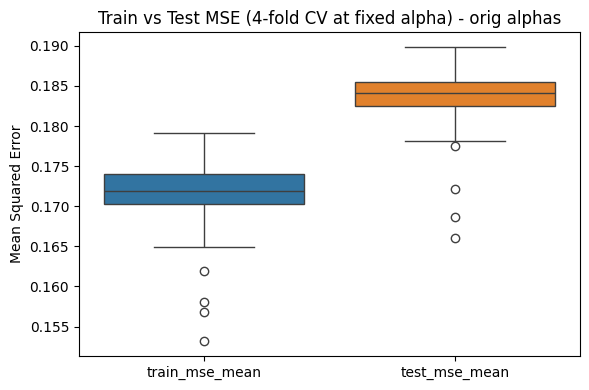

In [30]:
import pandas as pd

# Flatten into long-form DataFrame
df = pd.DataFrame.from_dict(old_sigmoid_final_model_results, orient="index")
df["pTF"] = df.index
df_long = df.melt(id_vars="pTF", value_vars=["train_mse_mean", "test_mse_mean"],
                  var_name="Split", value_name="MSE")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_long, x="Split", y="MSE", palette=["#1f77b4", "#ff7f0e"])
plt.title("Train vs Test MSE (4-fold CV at fixed alpha) - orig alphas")
plt.ylabel("Mean Squared Error")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [31]:
df_long[df_long.Split == "test_mse_mean"].MSE.mean()

0.18365275740649967

/tmp/ipykernel_11250/3941487909.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x="Split", y="MSE", palette=["#1f77b4", "#ff7f0e"])


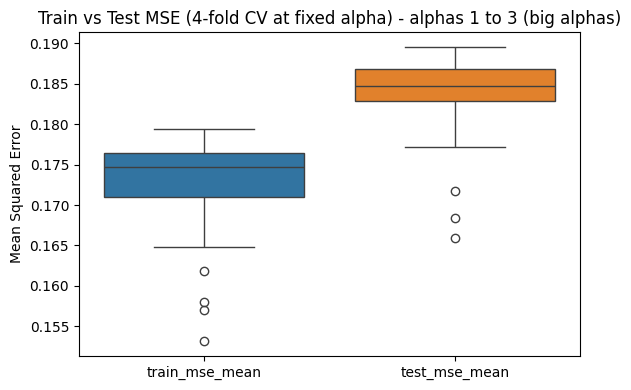

In [ ]:
import pandas as pd

# Flatten into long-form DataFrame
df = pd.DataFrame.from_dict(old_sigmoid_big_alpha_final_model_results, orient="index")
df["pTF"] = df.index
df_long = df.melt(id_vars="pTF", value_vars=["train_mse_mean", "test_mse_mean"],
                  var_name="Split", value_name="MSE")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_long, x="Split", y="MSE", palette=["#1f77b4", "#ff7f0e"])
plt.title("Train vs Test MSE (4-fold CV at fixed alpha) - alphas 1 to 3 (big alphas)")
plt.ylabel("Mean Squared Error")
plt.xlabel("")
plt.tight_layout()
plt.show()

/tmp/ipykernel_11250/2147650667.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x="Split", y="MSE", palette=["#1f77b4", "#ff7f0e"])


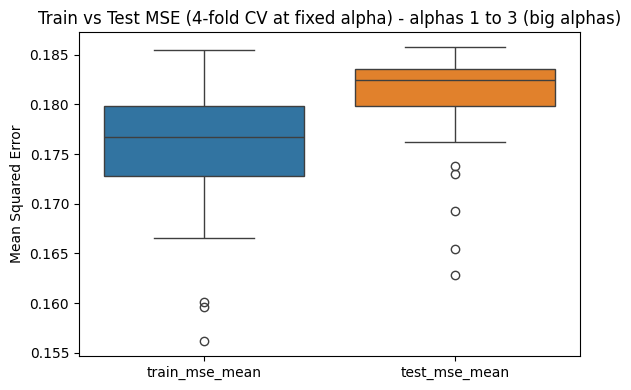

In [53]:
import pandas as pd

# Flatten into long-form DataFrame
df = pd.DataFrame.from_dict(old_sigmoid_01_100_alpha_final_model_results, orient="index")
df["pTF"] = df.index
df_long = df.melt(id_vars="pTF", value_vars=["train_mse_mean", "test_mse_mean"],
                  var_name="Split", value_name="MSE")

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_long, x="Split", y="MSE", palette=["#1f77b4", "#ff7f0e"])
plt.title("Train vs Test MSE (4-fold CV at fixed alpha) - alphas 1 to 3 (big alphas)")
plt.ylabel("Mean Squared Error")
plt.xlabel("")
plt.tight_layout()
plt.show()

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_train_test_curve(model, pTF):
    test_mse = np.mean(model.cv_scores_, axis=1)
    alphas = model.alphas_

    # (Optional) if you recorded train MSEs per fold, you'd average them similarly
    # train_mse = np.mean(model.cv_train_scores_, axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(alphas, test_mse, label="Test MSE", marker='o')

    # If you have train_mse: plot it
    # plt.plot(alphas, train_mse, label="Train MSE", marker='s')

    plt.xscale("log")
    plt.gca().invert_xaxis()  # optional: reverse axis to match typical lambda plots
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("Mean Squared Error")
    plt.title(f"MSE vs Alpha for {pTF}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


DEBUG:matplotlib.ticker:vmin 158.48931924611142 vmax 0.00630957344480193
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])
DEBUG:matplotlib.ticker:vmin 158.48931924611142 vmax 0.00630957344480193
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04])
DEBUG:matplotlib.ticker:vmin 158.48931924611142 vmax 0.006309

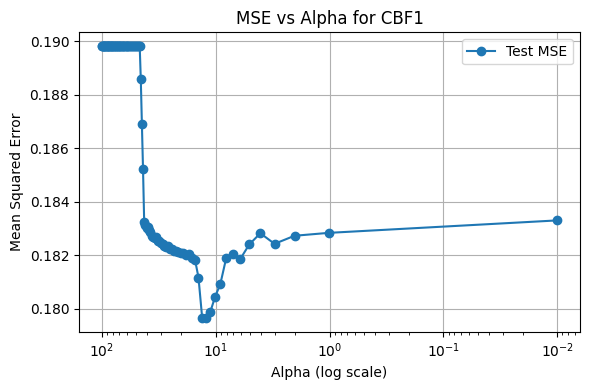

In [41]:
plot_train_test_curve(results_objects["old_sigmoid_01_100_alpha"]["CBF1"], "CBF1")

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_train_test_curves(models_dict, show_train=False, title="MSE vs Alpha (All TFs)", alpha=0.6):
    plt.figure(figsize=(10, 6))

    for pTF, model in models_dict.items():
        alphas = model.alphas_
        #test_mse = np.mean(model.cv_scores_, axis=1)
        test_mse = np.mean(model.mse_path_, axis=1)

        # Optional: estimate train MSE per alpha if available/stored
        # train_mse = np.mean(model.cv_train_scores_, axis=1)

        plt.plot(alphas, test_mse, label=f"{pTF} - Test", alpha=alpha)

        # Uncomment this if you have train MSEs stored
        # if show_train and hasattr(model, "cv_train_scores_"):
        #     plt.plot(alphas, train_mse, linestyle="--", label=f"{pTF} - Train", alpha=alpha)

    plt.xscale("log")
    #plt.gca().invert_xaxis()
    plt.xlabel("Alpha (log scale)")
    plt.ylabel("Mean Squared Error")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    # Optional: show legend only if few TFs
    if len(models_dict) <= 10:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    plt.show()


DEBUG:matplotlib.ticker:vmin 0.00630957344480193 vmax 158.48931924611142
DEBUG:matplotlib.ticker:ticklocs array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])
DEBUG:matplotlib.ticker:vmin 0.00630957344480193 vmax 158.48931924611142
DEBUG:matplotlib.ticker:ticklocs array([2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04])
DEBUG:matplotlib.ticker:vmin 0.00630957344480193 vmax 158.489

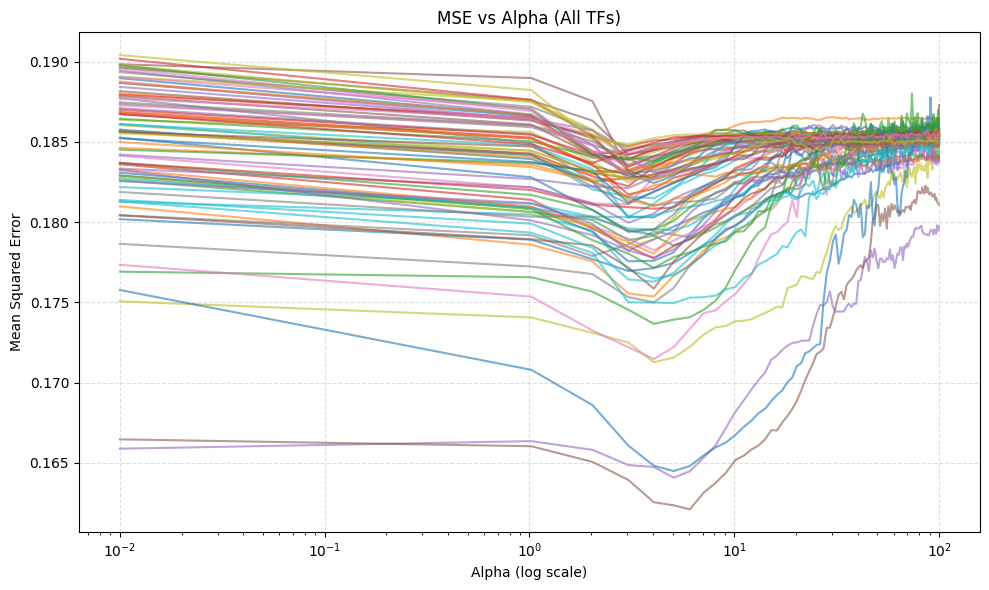

In [43]:
plot_all_train_test_curves(results_objects["norm_predictors"])

In [54]:
alphas = np.mean([model.alpha_ for model in results_objects["old_sigmoid_01_100_alpha"].values()])
print(f"Mean alpha across models: {alphas:.4f}")

Mean alpha across models: 10.8331


Summary:
count    58.000000
mean     31.724138
std       9.741921
min       5.000000
25%      26.000000
50%      33.000000
75%      38.000000
max      49.000000
Name: Non-Zero Coefficients, dtype: float64


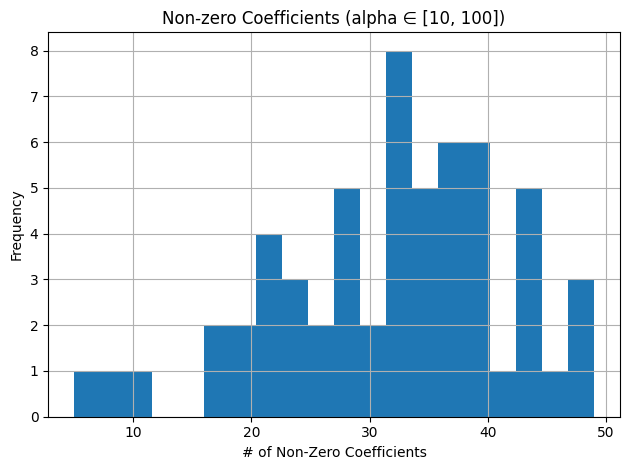

In [50]:
non_zero_counts = {}

for tf, model in results_objects["old_sigmoid_01_100_alpha"].items():
    alpha = model.alpha_
    if 10 <= alpha <= 50:
        non_zero = np.sum(np.abs(model.coef_) > 1e-2)
        non_zero_counts[tf] = non_zero

import pandas as pd

df = pd.Series(non_zero_counts, name="Non-Zero Coefficients")
print("Summary:")
print(df.describe())

# Histogram
df.plot.hist(bins=20, title="Non-zero Coefficients (alpha ∈ [10, 100])")
plt.xlabel("# of Non-Zero Coefficients")
plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
results_objects.get("old_sigmoid_01_100_alpha").get("CBF1").alpha_

12.13

In [47]:
results_objects.get("old_sigmoid_01_100_alpha").get("CBF1").coef_

array([ 1.93207780e-02,  7.81525719e-04, -1.55754213e-04, -3.60156727e-03,
       -2.77141930e-03,  5.97085394e-04,  5.12923948e-03, -4.00609282e-04,
        1.16725899e-02, -1.49432280e-02, -1.96821953e-02,  9.95185956e-04,
       -1.77741511e-03,  6.39645690e-04,  6.68876742e-03, -1.24681254e-03,
        4.02675731e-04, -4.74592669e-03, -6.31877281e-03,  7.15912754e-04,
        3.72964050e-04, -1.26115767e-03,  9.10626137e-03, -3.10036675e-03,
       -4.19157087e-03, -1.15863908e-02,  1.75153271e-03,  7.45910094e-03,
       -9.60843706e-03, -1.78287556e-03,  1.68406320e-02,  1.45003333e-04,
       -3.01842099e-04,  3.74006146e-03, -2.45468665e-03, -9.20878956e-03,
        1.18082608e-03,  1.37083075e-02, -1.65064216e-02,  3.83579692e-03,
        3.26392302e-03,  1.89530104e-03,  2.00453047e-04, -9.98320814e-03,
        5.99659905e-03, -2.05014268e-03, -6.16831012e-03,  2.37885563e-02,
       -4.57867008e-03,  6.08862636e-03,  1.39252394e-02,  6.57331245e-03,
       -2.71957563e-03,  

In [ ]:
def create_model_frame(pTF, predictors_df, response_df):
    input_data = ModelingInputData(
        response_df=response_df,
        predictors_df=predictors_df,
        perturbed_tf=pTF,
        top_n=600,
    )
    input_data.top_n_masked = False
    predictor_variables = input_data.predictors_df.columns.drop(
        input_data.perturbed_tf
    )
    interaction_terms = [
        f"{input_data.perturbed_tf}:{var}" for var in predictor_variables if var != "red_median"
    ]
    formula = f"{input_data.perturbed_tf} + {' + '.join(interaction_terms)}"
    model_df = input_data.get_modeling_data(formula, drop_intercept=True)
    return model_df, input_data.response_df

response_frames_path = "/home/chase/htcf_ref/data/yeast_database_modeling/pull_data_20241231/response_frames/"
response_frames = {
    key: pd.read_csv(os.path.join(response_frames_path, f"{key}.csv"))
    for key in results_objects.get("sigmoid").get("incl_intercept").keys()
}

model_response_frames = {
    key: create_model_frame(key, predictors_df, response_df)
    for key, response_df in response_frames.items()
}

INFO:main:Response column names: Index(['ACA1'], dtype='object')
INFO:main:Common features between response and predictors: 6066. Subsetting and reordering both dataframes.
INFO:main:Number of blacklisted features: 0
INFO:main:Selected 544 top features based on descending ranking of predictors_df['ACA1'].
INFO:main:Top-n feature masking enabled.
INFO:main:Top-n feature masking disabled.
INFO:main:Response column names: Index(['ACE2'], dtype='object')
INFO:main:Common features between response and predictors: 6066. Subsetting and reordering both dataframes.
INFO:main:Number of blacklisted features: 0
INFO:main:Selected 375 top features based on descending ranking of predictors_df['ACE2'].
INFO:main:Top-n feature masking enabled.
INFO:main:Top-n feature masking disabled.
INFO:main:Response column names: Index(['AFT1'], dtype='object')
INFO:main:Common features between response and predictors: 6066. Subsetting and reordering both dataframes.
INFO:main:Number of blacklisted features: 0
INF

In [21]:
def add_score_(pTF, obj):
    obj.score_ = obj.score(
        model_response_frames[pTF][0],
        model_response_frames[pTF][1].squeeze()
    )
    return obj

results_objects["lasso"] = {key: add_score_(key, value) for key, value in results_objects.get("lasso").items()}

In [47]:
results_objects.get("old_sigmoid").get("CBF1").mse

0.17090551733670592

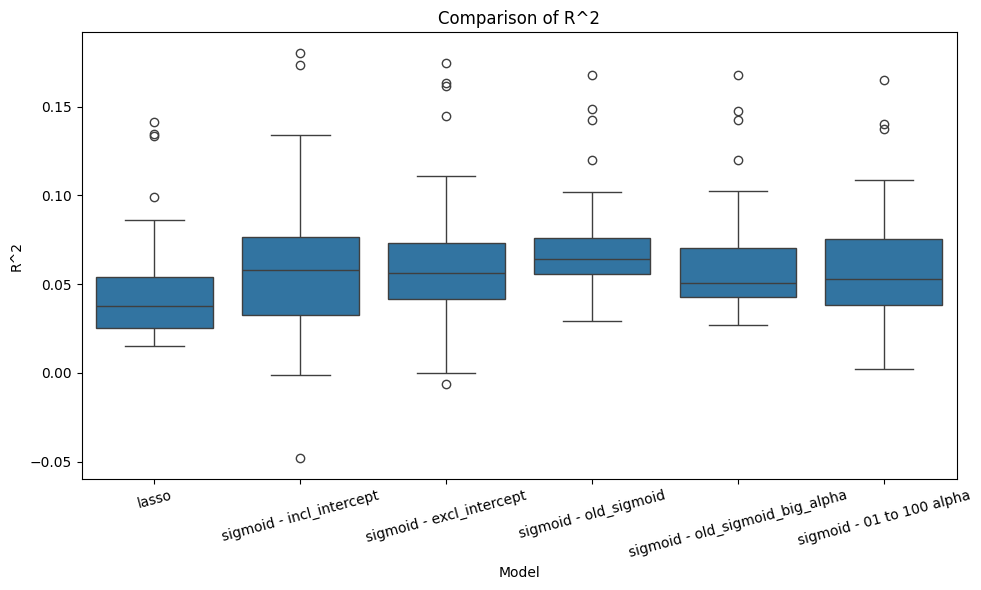

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the scores for each category
lasso_scores = [
    obj.score_ for obj in results_objects.get("lasso").values()
]

sigmoid_incl_scores = [
    obj.score_ for obj in results_objects.get("sigmoid").get("incl_intercept").values()
]

sigmoid_excl_scores = [
    obj.score_ for obj in results_objects.get("sigmoid").get("excl_intercept").values()
]

old_sigmoid_scores = [
    obj.r_squared for obj in results_objects.get("old_sigmoid").values()
]

old_sigmoid_scores_big_alpha = [
    obj.r_squared for obj in results_objects.get("old_sigmoid_big_alpha").values()
]

old_sigmoid_01_100 = [
    obj.r_squared for obj in results_objects.get("old_sigmoid_01_100_alpha").values()
]

# Combine the data into a single structure for plotting
data = {
    "lasso": lasso_scores,
    "sigmoid - incl_intercept": sigmoid_incl_scores,
    "sigmoid - excl_intercept": sigmoid_excl_scores,
    "sigmoid - old_sigmoid": old_sigmoid_scores,
    "sigmoid - old_sigmoid_big_alpha": old_sigmoid_scores_big_alpha,
    "sigmoid - 01 to 100 alpha": old_sigmoid_01_100,
}

# Convert the data into a format suitable for seaborn
plot_data = []
for category, scores in data.items():
    for score in scores:
        plot_data.append({"Category": category, "Score": score})

# Create a DataFrame for plotting
import pandas as pd
df = pd.DataFrame(plot_data)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Category", y="Score", data=df)
plt.title("Comparison of R^2")
plt.xlabel("Model")
plt.ylabel("R^2")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [ ]:
results_objects.get("old_sigmoid").get("CBF1").alphas_

4.883894199343892e-13

DEBUG:matplotlib.ticker:vmin 0.02728444611968986 vmax 1.3674616071779715e-05
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.02728444611968986 vmax 1.3674616071779715e-05
DEBUG:matplotlib.ticker:ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00])
DEBUG:matplotlib.ticker:vmin 0.02728444611968986 vmax 1.3674616071779715e-05
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])


DEBUG:matplotlib.ticker:vmin 0.02728444611968986 vmax 1.3674616071779715e-05
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.02728444611968986 vmax 1.3674616071779715e-05
DEBUG:matplotlib.ticker:ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00])
DEBUG:matplotlib.ticker:vmin 0.02728444611968986 vmax 1.3674616071779715e-05
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.0272844461196

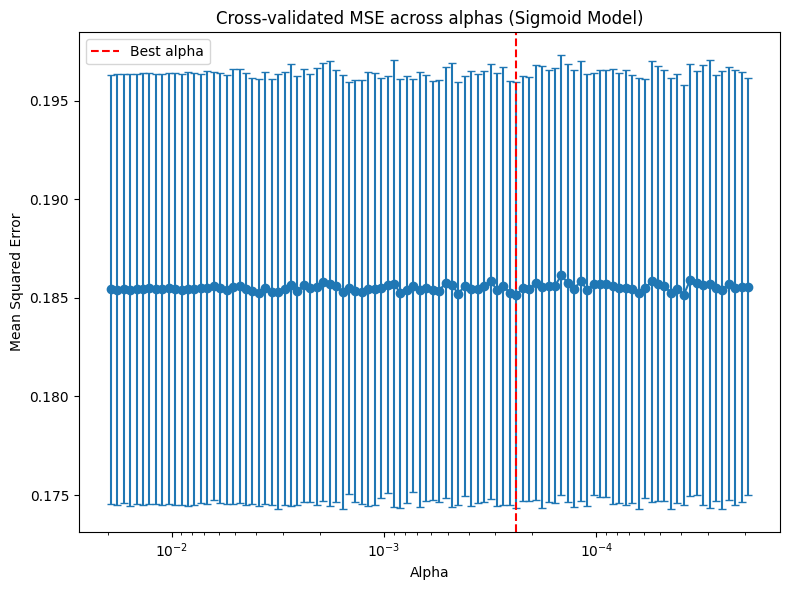

In [22]:
import matplotlib.pyplot as plt
import numpy as np

gle_l1 = sigmoid_results.get("ACA1").get("ACA1")  # or however you store it

alphas = list(gle_l1.mse_path_.keys())
means = [np.mean(gle_l1.mse_path_[a]) for a in alphas]
stds = [np.std(gle_l1.mse_path_[a]) for a in alphas]

plt.figure(figsize=(8, 6))
plt.errorbar(alphas, means, yerr=stds, fmt="o-", capsize=3)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("Cross-validated MSE across alphas (Sigmoid Model)")
plt.gca().invert_xaxis()

# Optional: mark best alpha
best_alpha = min(gle_l1.mse_path_, key=lambda a: np.mean(gle_l1.mse_path_[a]))
plt.axvline(best_alpha, linestyle="--", color="red", label="Best alpha")
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
import plotly.graph_objects as go

# Define colors for each group
colors = {
    "lasso": "blue",
    "sigmoid - incl_intercept": "green",
    "sigmoid - excl_intercept": "orange",
    "sigmoid - old sigmoid": "red",
}

# Prepare data for plotting
groups = {
    "lasso": results_objects.get("lasso"),
    "sigmoid - incl_intercept": results_objects.get("sigmoid").get("incl_intercept"),
    "sigmoid - excl_intercept": results_objects.get("sigmoid").get("excl_intercept"),
    "sigmoid - old sigmoid": results_objects.get("old_sigmoid")
}

# Create a plotly figure
fig = go.Figure()

for group_name, group_data in groups.items():
    for pTF, model in group_data.items():
        if group_name == "lasso":
            alphas = model.alphas_
            means = [np.mean(folds) for folds in model.mse_path_]
        elif group_name in ["sigmoid - incl_intercept", "sigmoid - excl_intercept"]:
            alphas = list(model.mse_path_.keys())
            means = [np.mean(model.mse_path_[a]) for a in alphas]
        else:
            alphas = model.alphas_
            means = [np.mean(folds) for folds in model.cv_scores_]

        # Add scatter points to the plotly figure
        fig.add_trace(
            go.Scatter(
                x=alphas,
                y=means,
                mode="markers",
                marker=dict(color=colors[group_name], size=5, opacity=0.6),
                name=f"{group_name} - {pTF}",
                text=[f"pTF: {pTF}" for _ in alphas],  # Hover text
                hoverinfo="text+x+y",  # Show hover text, x, and y values
            )
        )

# Configure the layout
fig.update_layout(
    title="Cross-validated MSE across alphas",
    xaxis=dict(title="Alpha", type="log", autorange="reversed"),  # Log scale and reversed
    yaxis=dict(title="Mean Squared Error"),
    legend_title="Groups",
    template="plotly_white",
)

# Show the interactive plot
fig.show()

DEBUG:matplotlib.ticker:vmin 0.12669774016171378 vmax 5.870451605608998e-06
DEBUG:matplotlib.ticker:ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01])
DEBUG:matplotlib.ticker:vmin 0.12669774016171378 vmax 5.870451605608998e-06
DEBUG:matplotlib.ticker:ticklocs array([2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07,
       2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01])
DEBUG:matplotlib.ticker:vmin 0.12669774016171378 vmax 5

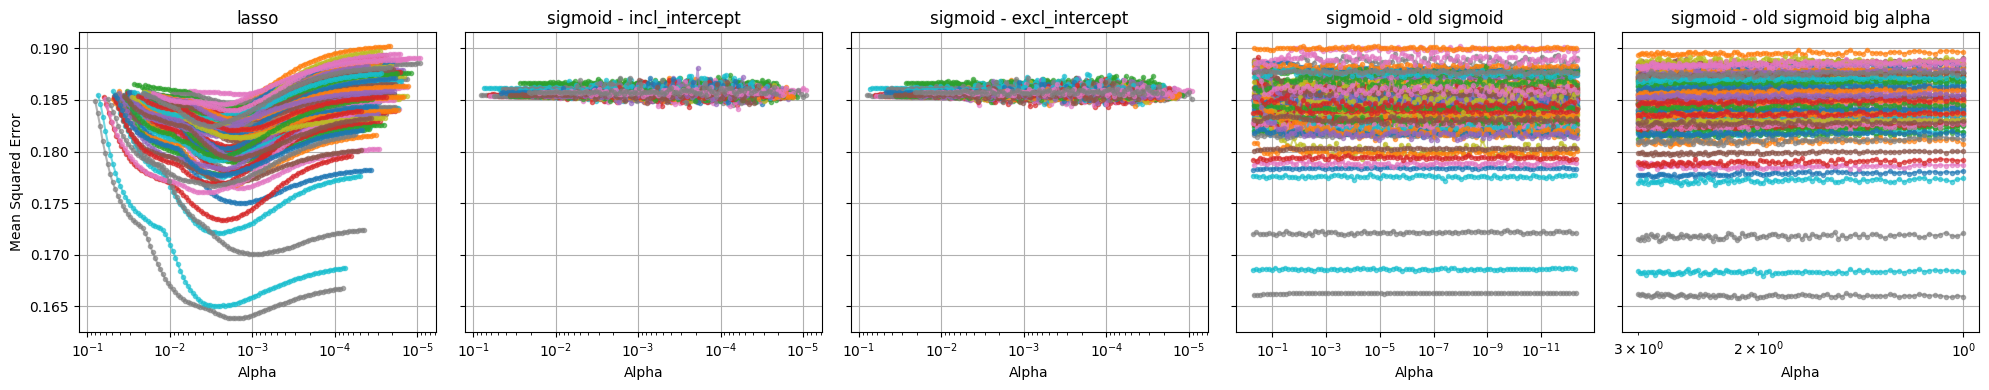

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each group
colors = {
    "lasso": "blue",
    "sigmoid - incl_intercept": "green",
    "sigmoid - excl_intercept": "orange",
    "sigmoid - old sigmoid": "red",
    "sigmoid - old sigmoid big alpha": "purple",
}

# Prepare data for plotting
groups = {
    "lasso": results_objects.get("lasso"),
    "sigmoid - incl_intercept": results_objects.get("sigmoid").get("incl_intercept"),
    "sigmoid - excl_intercept": results_objects.get("sigmoid").get("excl_intercept"),
    "sigmoid - old sigmoid": results_objects.get("old_sigmoid"),
    "sigmoid - old sigmoid big alpha": results_objects.get("old_sigmoid_big_alpha"),
}

# Create 1x4 subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for ax, (group_name, group_data) in zip(axes, groups.items()):
    for pTF, model in group_data.items():
        if group_name == "lasso":
            alphas = model.alphas_
            means = [np.mean(folds) for folds in model.mse_path_]
        elif group_name in ["sigmoid - incl_intercept", "sigmoid - excl_intercept"]:
            alphas = list(model.mse_path_.keys())
            means = [np.mean(model.mse_path_[a]) for a in alphas]
        else:
            alphas = model.alphas_
            means = [np.mean(folds) for folds in model.cv_scores_]

        ax.plot(alphas, means, marker='o', linestyle='-', markersize=3, alpha=0.6)

    ax.set_xscale('log')
    ax.invert_xaxis()  # Match Plotly reversed alpha axis
    ax.set_title(group_name)
    ax.set_xlabel('Alpha')
    ax.grid(True)

axes[0].set_ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()


In [54]:
results_objects.get("old_sigmoid").get("CBF1").cv_scores_

AttributeError: 'GeneralizedLogisticModel' object has no attribute 'cv_scores_'

DEBUG:matplotlib.ticker:vmin 0.027284449280562003 vmax 1.3674617655968482e-05
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.027284449280562003 vmax 1.3674617655968482e-05
DEBUG:matplotlib.ticker:ticklocs array([2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00])
DEBUG:matplotlib.ticker:vmin 0.027284449280562003 vmax 1.3674617655968482e-05
DEBUG:matplotlib.ticker:ticklocs array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])
DEBUG:matplotlib.ticker:vmin 0.0272844492

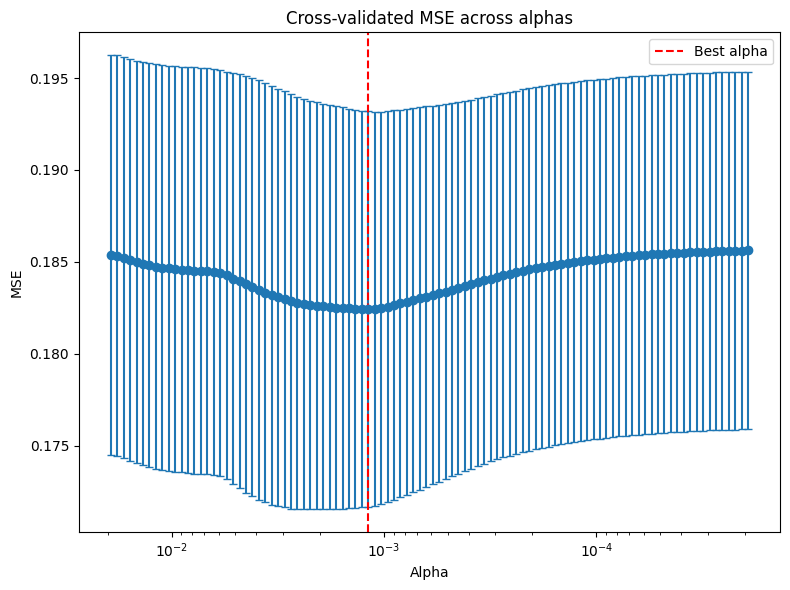

In [23]:
lasso_cv = lasso_results.get("ACA1").get("ACA1") 

# Get cross-validation results
alphas = lasso_cv.alphas_
mse_path = lasso_cv.mse_path_  # shape (n_alphas, n_folds)

# Convert to R² if you want to match your sigmoid plots
# (optional, depending on what you're comparing to)
# r2_path = 1 - mse_path / np.var(y)  # only valid if y is centered

# Mean and standard deviation
mean_mse = mse_path.mean(axis=1)
std_mse = mse_path.std(axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(alphas, mean_mse, yerr=std_mse, fmt="o-", capsize=3)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("MSE")
plt.title("Cross-validated MSE across alphas")
plt.gca().invert_xaxis()
plt.axvline(lasso_cv.alpha_, linestyle="--", color="red", label="Best alpha")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
gle_l1.score(bootstrapped_data_all.model_df, bootstrapped_data_all.response_df.squeeze())

0.10472057702161774

In [12]:
gle_l1.mse_path_

{0.034894332193876235: [0.20694553552998535,
  0.1679273995443859,
  0.19220413142048046,
  0.17461545380801158],
 0.03254257099126386: [0.20698452335918957,
  0.16785867313490985,
  0.1921346578170741,
  0.17460138510998247],
 0.03034931062263746: [0.20695287239652674,
  0.16776004348924622,
  0.19223288369811645,
  0.17460887278957787],
 0.028303868662270155: [0.20696460864015703,
  0.16782725519932534,
  0.19223655018311575,
  0.17456909392453077],
 0.02639628264417623: [0.206955281762768,
  0.1678632087863957,
  0.19229834374232468,
  0.17459507448926506],
 0.02461726153923419: [0.20697833387446007,
  0.16782623730487842,
  0.19223478993587476,
  0.17460304536588053],
 0.02295814050258937: [0.20692216985082798,
  0.1677956690041708,
  0.19217069961932062,
  0.17455300668531346],
 0.021410838670930056: [0.20691358748163854,
  0.16774940156326454,
  0.19215830740720413,
  0.17451114640316562],
 0.019967819804086046: [0.20705113652758775,
  0.16779501365641547,
  0.19222200806283182,


DEBUG:matplotlib.ticker:vmin 4.1132957329299594e-06 vmax 0.00820710396623745
DEBUG:matplotlib.ticker:ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])
DEBUG:matplotlib.ticker:vmin 4.1132957329299594e-06 vmax 0.00820710396623745
DEBUG:matplotlib.ticker:ticklocs array([2.e-07, 3.e-07, 4.e-07, 5.e-07, 6.e-07, 7.e-07, 8.e-07, 9.e-07,
       2.e-06, 3.e-06, 4.e-06, 5.e-06, 6.e-06, 7.e-06, 8.e-06, 9.e-06,
       2.e-05, 3.e-05, 4.e-05, 5.e-05, 6.e-05, 7.e-05, 8.e-05, 9.e-05,
       2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04, 8.e-04, 9.e-04,
       2.e-03, 3.e-03, 4.e-03, 5.e-03, 6.e-03, 7.e-03, 8.e-03, 9.e-03,
       2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01])
DEBUG:matplotlib.ticker:vmin 4.1132957329299594e-06 vmax 0.00820710396623745
DEBUG:matplotlib.ticker:ticklocs array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])
DEBUG:matplotlib.ticker:vmin 4.1132957329299

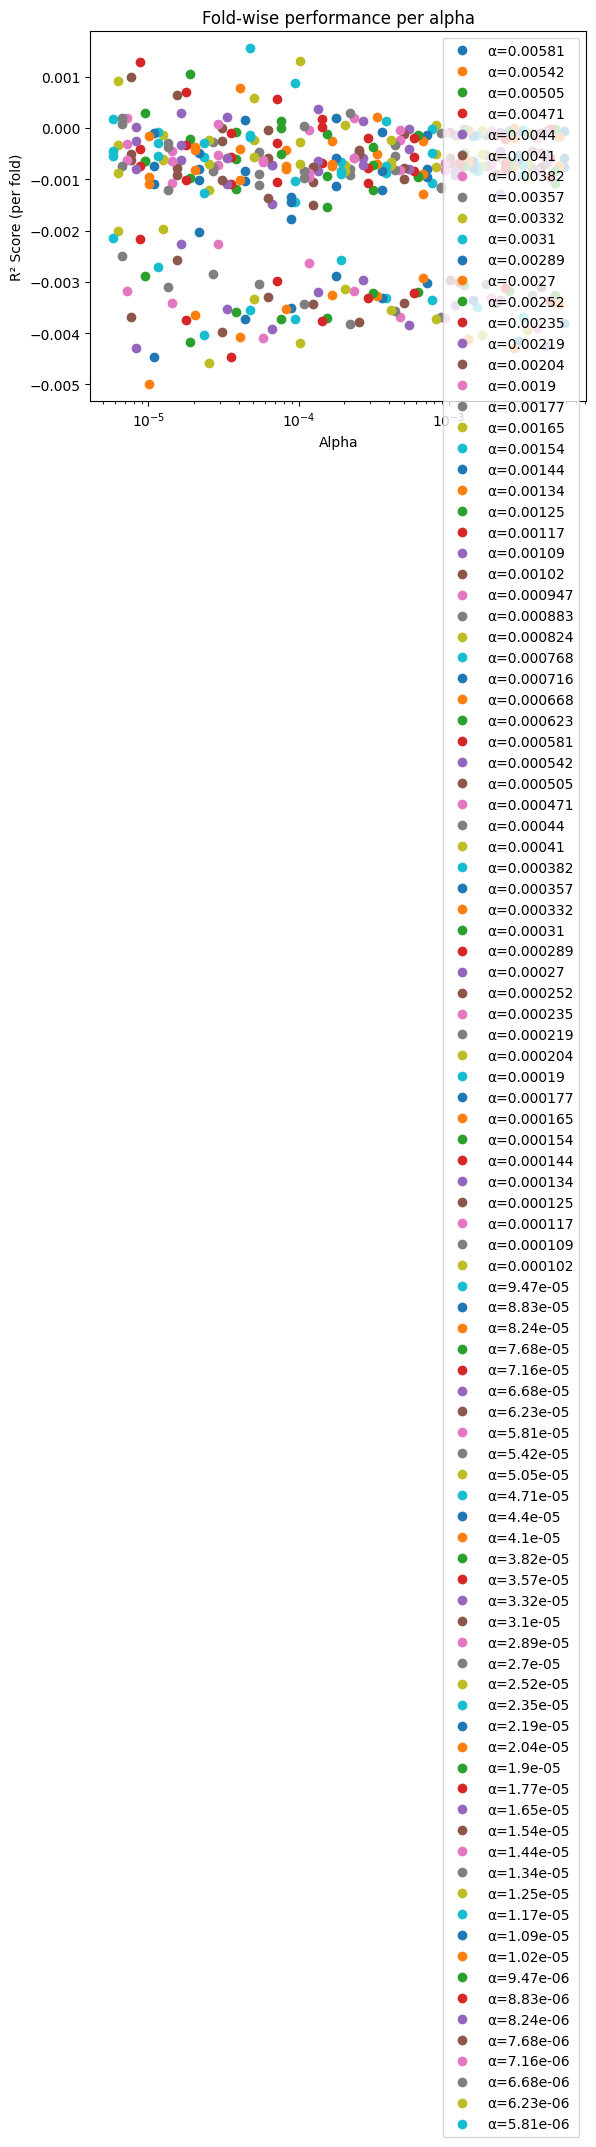

In [58]:
for alpha, fold_scores in gle_l1.score_path_.items():
    plt.plot([alpha] * len(fold_scores), fold_scores, 'o', label=f'α={alpha:.3g}')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R² Score (per fold)')
plt.title('Fold-wise performance per alpha')
plt.legend()
plt.show()


In [62]:
print("left_asymptote:", gle_l1.estimator_.left_asymptote_)
print("right_asymptote:", gle_l1.estimator_.right_asymptote_)
print("intercept: ", gle_l1.estimator_.intercept_)

left_asymptote: -0.581849217414856
right_asymptote: 1.6645212173461914
intercept:  -0.21997103


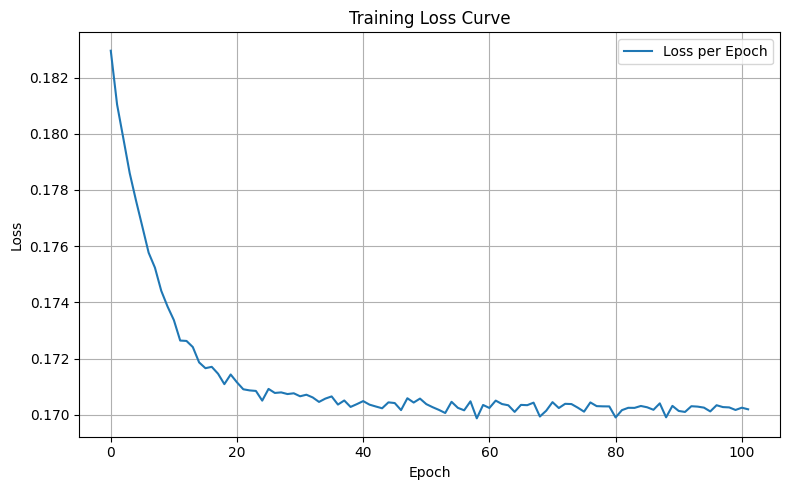

In [60]:
import matplotlib.pyplot as plt

def visualize_loss_curve(loss_history):
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label="Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


visualize_loss_curve(gle_l1.estimator_.loss_history)

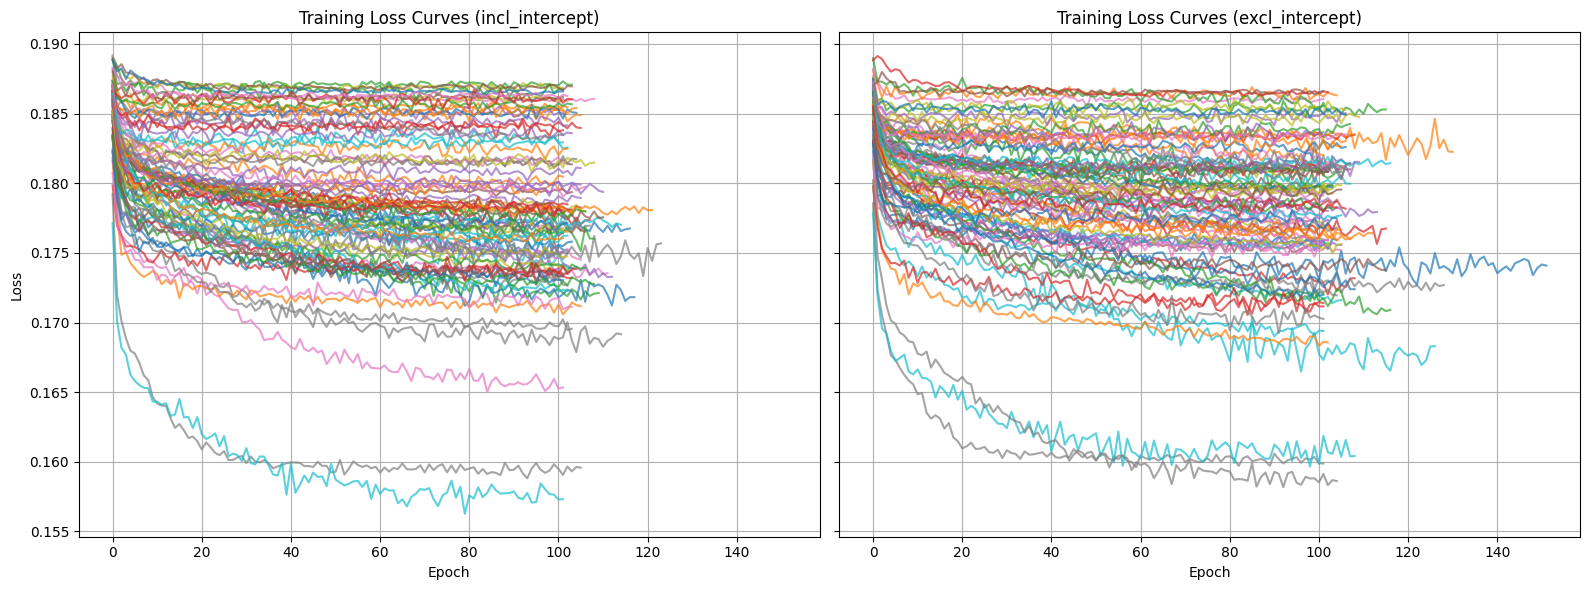

In [88]:
import matplotlib.pyplot as plt

def visualize_loss_curves_side_by_side(incl_data, excl_data):
    """
    Visualize the loss history for incl_intercept and excl_intercept side by side.
    
    :param incl_data: Dictionary of pTFs and their models for incl_intercept.
    :param excl_data: Dictionary of pTFs and their models for excl_intercept.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

    # Plot for incl_intercept
    axes[0].set_title("Training Loss Curves (incl_intercept)")
    for pTF, model in incl_data.items():
        loss_history = model.estimator_.loss_history
        axes[0].plot(loss_history, alpha=0.7)  # Add transparency for clarity
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True)

    # Plot for excl_intercept
    axes[1].set_title("Training Loss Curves (excl_intercept)")
    for pTF, model in excl_data.items():
        loss_history = model.estimator_.loss_history
        axes[1].plot(loss_history, alpha=0.7)  # Add transparency for clarity
    axes[1].set_xlabel("Epoch")
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Prepare data
incl_intercept_data = results_objects.get("sigmoid").get("incl_intercept")
excl_intercept_data = results_objects.get("sigmoid").get("excl_intercept")

# Visualize side by side
visualize_loss_curves_side_by_side(incl_intercept_data, excl_intercept_data)

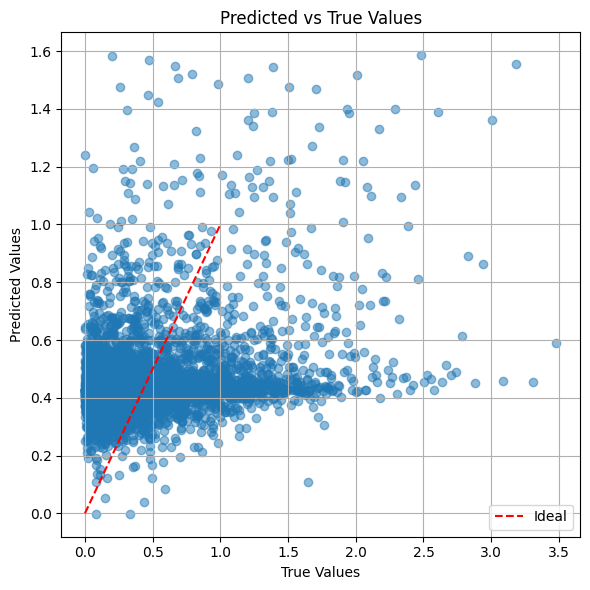

In [53]:
def plot_predicted_vs_true(y_true, y_pred):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs True Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predicted_vs_true(
    bootstrapped_data_all.response_df.squeeze(),
    gle_l1.predict(bootstrapped_data_all.model_df),
)

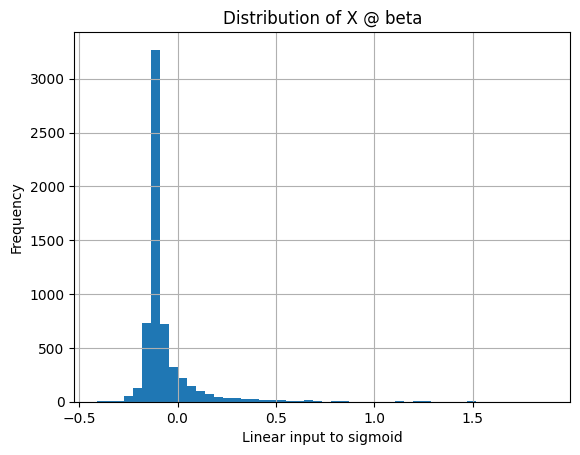

In [44]:
X = bootstrapped_data_all.model_df.to_numpy().astype(np.float32)

if gle_l1.fit_intercept:
    # prepend column of ones
    X = np.column_stack([np.ones(X.shape[0], dtype=np.float32), X])

beta = gle_l1.estimator_.model_.beta.detach().numpy()
linear_input = X @ beta

plt.hist(linear_input, bins=50)
plt.title("Distribution of X @ beta")
plt.xlabel("Linear input to sigmoid")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


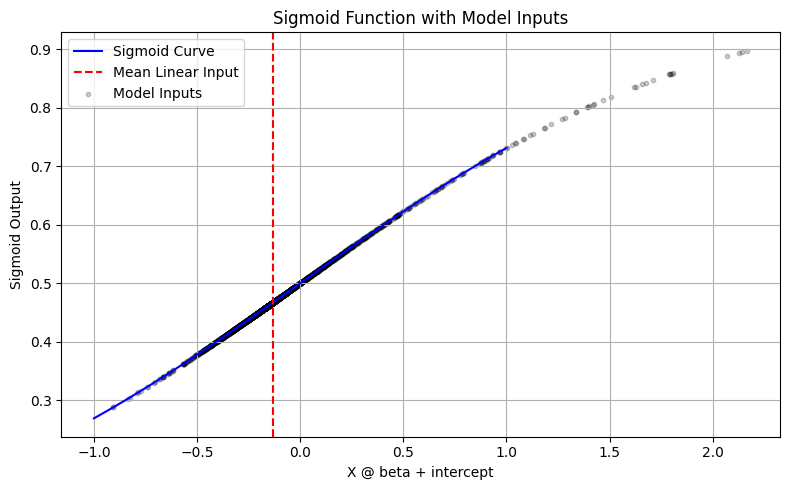

In [28]:
from scipy.special import expit
import matplotlib.pyplot as plt
import numpy as np

# Compute sigmoid function
z = np.linspace(-1, 1, 500)
y = expit(z)

# Compute X @ beta + intercept
beta = gle_l1.estimator_.coef_
intercept = gle_l1.estimator_.intercept_
X = bootstrapped_data_all.model_df.values
linear_input = X @ beta + intercept
sigmoid_output = expit(linear_input)

# Plot sigmoid curve
plt.figure(figsize=(8, 5))
plt.plot(z, y, label="Sigmoid Curve", color='blue')

# Add vertical line for mean of actual input
plt.axvline(x=np.mean(linear_input), color='red', linestyle='--', label="Mean Linear Input")

# Overlay actual model inputs
plt.scatter(linear_input, sigmoid_output, alpha=0.2, color='black', label="Model Inputs", s=10)

# Annotate
plt.title("Sigmoid Function with Model Inputs")
plt.xlabel("X @ beta + intercept")
plt.ylabel("Sigmoid Output")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


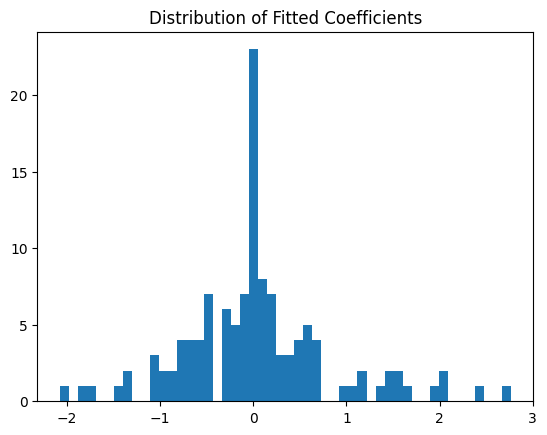

In [29]:
plt.hist(gle_l1.estimator_.coef_, bins=50)
plt.title("Distribution of Fitted Coefficients")
plt.show()

Let 

$R = \text{right asymptote}$

$L = \text{left asymptote}$

$\delta = R - L$

$\sigma = \frac{1}{1 + e^{-Xb}}$ where $X$ is the $n \times p$ model matrix in
the format $[1, var1, var2, ...]$ and $b$ is a $p \times 1$ the coefficient vector.


$$

f(x)=(R−L)⋅\sigma(z)+L=\delta⋅\sigma(z)+L

$$

The range is $(L, R)$ and the domain is $x \in (-\infty, \infty)$.

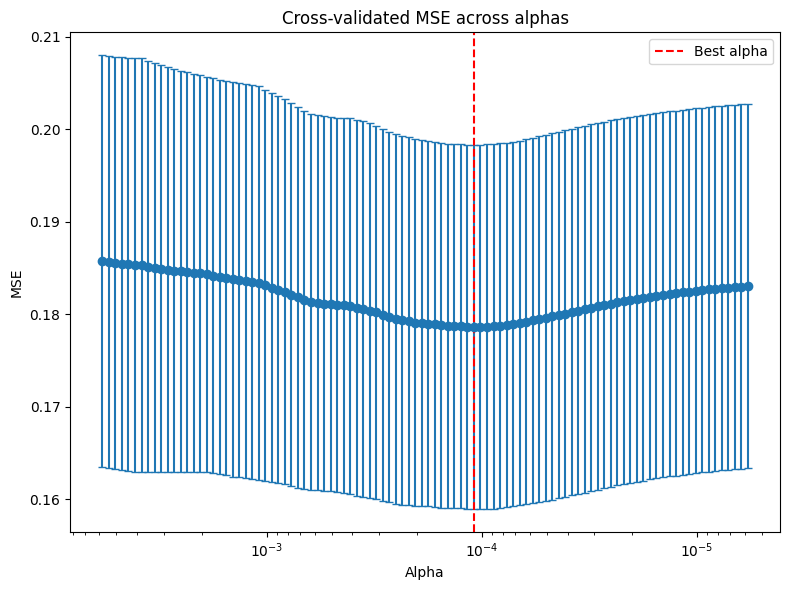

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

# Fit your model
lasso_cv = LassoCV(cv=4, random_state=42)
lasso_cv.fit(bootstrapped_data_all.model_df, bootstrapped_data_all.response_df.squeeze())

# Get cross-validation results
alphas = lasso_cv.alphas_
mse_path = lasso_cv.mse_path_  # shape (n_alphas, n_folds)

# Convert to R² if you want to match your sigmoid plots
# (optional, depending on what you're comparing to)
# r2_path = 1 - mse_path / np.var(y)  # only valid if y is centered

# Mean and standard deviation
mean_mse = mse_path.mean(axis=1)
std_mse = mse_path.std(axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(alphas, mean_mse, yerr=std_mse, fmt="o-", capsize=3)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("MSE")
plt.title("Cross-validated MSE across alphas")
plt.gca().invert_xaxis()
plt.axvline(lasso_cv.alpha_, linestyle="--", color="red", label="Best alpha")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import os

results_path = "/home/chase/htcf_local/normalized_data_models_squared_pTF_20250408"

response_frames = "/home/chase/htcf_ref/data/yeast_database_modelling/pull_data_20250325/normalized_mcisaac_response"


In [6]:

all_data_json_dicts = {}
for root, dirs, files in os.walk(results_path):
    for file in files:
        if file == 'all_data_significant_98-0.json':
            regulator = os.path.basename(root)
            all_data_json_dicts[regulator] = os.path.join(root, file)

In [7]:
all_data_json_dicts.keys()

dict_keys(['ACE2', 'ADA2', 'AFT1', 'ARG80', 'ARG81', 'ARO80', 'CBF1', 'CIN5', 'CRZ1', 'CST6', 'CUP9', 'FKH1', 'GAL11', 'GAL4', 'GAT2', 'GAT4', 'GCN4', 'GCN5', 'GCR2', 'GIS1', 'HAP3', 'HAP4', 'HCM1', 'HFI1', 'INO4', 'LEU3', 'LYS14', 'MED2', 'MET28', 'MET31', 'MET32', 'MIG1', 'MSN2', 'OAF1', 'OPI1', 'PDR1', 'PDR3', 'PGD1', 'PHO2', 'RDR1', 'RDS2', 'RFX1', 'RGT1', 'ROX1', 'RPH1', 'RPN4', 'RTG1', 'SFP1', 'SKN7', 'SKO1', 'STB5', 'STE12', 'STP1', 'STP2', 'SUM1', 'SWI5', 'TYE7', 'UME1', 'USV1', 'VHR1', 'WTM1', 'XBP1', 'YOX1', 'ZAP1'])

In [8]:
import pandas as pd

response_frames_dict = {
    x.replace(".csv", ""): pd.read_csv(os.path.join(response_frames, x))
    for x in os.listdir(response_frames)
    if x.endswith(".csv")
}

In [41]:
import pandas as pd
import warnings

from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

# Helper function to check if a CI is strictly positive or negative
def is_strictly_positive(ci):
    return ci[0] > 0 and ci[1] > 0

def is_strictly_negative(ci):
    return ci[0] < 0 and ci[1] < 0

def crosses_zero(ci):
    return ci[0] * ci[1] < 0

def classify_mTF_bins(df, mTF, quantile_cutoff, cap_n=None) -> pd.DataFrame:
    """
    Classify mTF into "Bottom", "Middle", and "Top" bins based on quantiles,
    with optional cap on number per bin for Bottom and Top.

    :param df: DataFrame with mTF values
    :param mTF: Column name for the modifier TF
    :param quantile_cutoff: Float, defines the proportion for "top" and "bottom" bins
    :param cap_n: Optional int, maximum number of rows to keep in each bin ("Bottom" and "Top" only)
    :return: DataFrame with an 'mTF_bin' column indicating "Bottom", "Middle", or "Top"
    """
    bottom_cutoff = df[mTF].quantile(quantile_cutoff)
    top_cutoff = df[mTF].quantile(1 - quantile_cutoff)

    # if either the bottom_cutoff or top_cutoff is greater than .50, raise a ValueError
    if bottom_cutoff > 0.50 or top_cutoff > 0.50:
        warnings.warn(f"Bottom cutoff or top cutoff is greater than 0.50: "
                      f"bottom_cutoff: {bottom_cutoff}; top_cutoff: {top_cutoff}",
                      category=UserWarning)

    df = df.copy()

    # Classify all rows into bins
    df["mTF_bin"] = np.select(
        condlist=[
            df[mTF] <= bottom_cutoff,
            df[mTF] >= top_cutoff
        ],
        choicelist=["Bottom", "Top"],
        default="Middle"
    )

    if cap_n is not None:
        bottom_df = df[df["mTF_bin"] == "Bottom"].nsmallest(cap_n, mTF)
        top_df = df[df["mTF_bin"] == "Top"].nlargest(cap_n, mTF)
        middle_df = df[df["mTF_bin"] == "Middle"]
        df = pd.concat([bottom_df, top_df, middle_df])

    return df

def classify_pTF_bin(df, pTF, threshold):
    df["pTF_bin"] = pd.cut(df[pTF], [-float("inf"), threshold, float("inf")], labels=["Low", "High"])
    return df

def compute_linear_slope(predictors, response, mTF_subset_index, pTF):
    """
    Fit a linear regression model: response[y_col] ~ predictors[x_col]
    using only the genes in mTF_subset_index.
    """
    common_idx = predictors.index.intersection(mTF_subset_index)
    x = predictors.loc[common_idx, pTF].values.reshape(-1, 1)
    y = response.loc[common_idx, pTF].values
    model = LinearRegression().fit(x, y)
    return model.coef_[0]

def compare_confidence_intervals(main_ci, interaction_ci):
    if main_ci is None:
        return "NA"
    if interaction_ci is None:
        raise KeyError("Missing interaction CI")

    if crosses_zero(main_ci) or crosses_zero(interaction_ci):
        warnings.warn(f"main CI: {main_ci}, interaction CI: {interaction_ci}. One or both cross zero.")
        return "NA"

    if is_strictly_positive(main_ci) and is_strictly_positive(interaction_ci):
        return "main effect greater" if main_ci[0] > interaction_ci[0] else "main effect less"
    if is_strictly_negative(main_ci) and is_strictly_negative(interaction_ci):
        return "main effect greater" if main_ci[1] < interaction_ci[1] else "main effect less"

    main_mag = abs(main_ci[0]) if is_strictly_negative(main_ci) else main_ci[0]
    inter_mag = abs(interaction_ci[0]) if is_strictly_negative(interaction_ci) else interaction_ci[0]
    return "main effect greater" if main_mag > inter_mag else "main effect less"

def get_interaction_term_chi_squared(data, predictors_df, response_df, threshold=0.6, quantile_cutoff=0.10):
    if quantile_cutoff > 0.50:
        raise ValueError(f"quantile_cutoff {quantile_cutoff} is invalid. "
                         "It must be less than or equal to 0.50")
    interaction_terms = [key for key in data if ':' in key]
    chi_squared_results = {}

    predictors_df_copy = predictors_df.copy()

    # drop the row where index == pTF
    predictors_df_copy = predictors_df_copy.drop(predictors_df_copy[predictors_df_copy.index == "pTF"].index)

    response_df_copy = response_df.copy()
    # drop the row where target_symbol == pTF
    response_df_copy = response_df_copy.drop(response_df_copy[response_df_copy["target_symbol"] == "pTF"].index)
    response_df_copy = response_df_copy.set_index('target_symbol')

    for term in interaction_terms:
        pTF, mTF = term.split(':')
        df = predictors_df_copy[[pTF, mTF]].dropna()

        df = classify_mTF_bins(df, mTF, quantile_cutoff)
        df = classify_pTF_bin(df, pTF, threshold)

        low_index = df[df["mTF_bin"] == "Bottom"].index
        high_index = df[df["mTF_bin"] == "Top"].index

        low_slope = compute_linear_slope(predictors_df_copy, response_df_copy, low_index, pTF)
        high_slope = compute_linear_slope(predictors_df_copy, response_df_copy, high_index, pTF)

        # Only consider Bottom and Top
        df_filtered = df[df["mTF_bin"].isin(["Bottom", "Top"])]

        contingency = pd.crosstab(df_filtered["pTF_bin"], df_filtered["mTF_bin"])
        chi2_stat, pvalue, dof, expected = chi2_contingency(contingency)
        expected_df = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)

        try:
            observed_gt_expected = contingency.loc["High", "Bottom"] > expected_df.loc["High", "Bottom"]
        except KeyError:
            observed_gt_expected = None

        compare_result = compare_confidence_intervals(data.get(pTF), data.get(term))

        chi_squared_results[term] = {
            "chi2_stat": chi2_stat,
            "pvalue": pvalue,
            "dof": dof,
            "expected_freq": expected_df,
            "raw_table": contingency,
            "Low_mTF_High_pTF_observed_gt_expected": observed_gt_expected,
            "main_effect_compare": compare_result,
            "ptf_by_low_mtf_slope": low_slope,
            "ptf_by_high_mtf_slope": high_slope,
            "mtf_low_index": low_index,
            "mtf_high_index": high_index,
        }

    return chi_squared_results


In [11]:
import json

predictors_df = pd.read_csv("predictors_normalized.csv")

predictors_df = predictors_df.set_index("target_symbol")


In [42]:
chisquared_res = {
    0.10 : {},
    0.15 : {},
    0.20 : {},
}

for quantile_cutoff in chisquared_res.keys():
    for key, value in all_data_json_dicts.items():
        with open(value, 'r') as f:
            data = json.load(f)
        # raise an error if key is already in chisquared_res
        if key in chisquared_res:
            raise KeyError(f"Key {key} already exists in chisquared_res")

        response_df = response_frames_dict.get(key)
        chisquared_res[quantile_cutoff][key] = get_interaction_term_chi_squared(
            data,
            predictors_df,
            response_df,
            quantile_cutoff=quantile_cutoff)

In [43]:
chisquared_res.get(0.10).get("ACE2").get("ACE2:PGD1").get("raw_table")

mTF_bin  Bottom  Top
pTF_bin             
Low        3938  593
High          1   18

In [53]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",   # important: cmbright is sans
    "text.latex.preamble": r"\usepackage{helvet}\renewcommand{\familydefault}{\sfdefault}",
    "text.color": "black",     # <-- this is the correct one
    "axes.labelcolor": "black",  # axis labels (x/y)
    "xtick.color": "black",      # x-axis tick labels
    "ytick.color": "black",      # y-axis tick labels"font.color": "black"
})


def latex_escape(text):
    """
    Escape special LaTeX characters in a text string.
    """
    # From matplotlib's internal escaping rules
    conv = {
        '&':  r'\&',
        '%':  r'\%',
        '$':  r'\$',
        '#':  r'\#',
        '_':  r'\_',
        '{':  r'\{',
        '}':  r'\}',
        '~':  r'\textasciitilde{}',
        '^':  r'\textasciicircum{}',
        '\\': r'\textbackslash{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in conv.keys()))
    return regex.sub(lambda match: conv[match.group()], text)

def plot_linear_fits(predictors, response, low_index, high_index, mTF, pTF, quantile_threshold):
    """
    Plot linear fits of pTF response ~ pTF binding strength for bottom/top mTF bins.

    :param predictors: DataFrame with TF binding values (indexed by target_symbol)
    :param response: DataFrame with perturbation response (indexed by target_symbol)
    :param low_index: Index of target_symbol in the bottom quantile for mTF
    :param high_index: Index of target_symbol in the top quantile for mTF
    :param mTF: modifier TF (used for bin labels)
    :param pTF: perturbed TF (x- and y-axis)
    """

    # Font size settings
    text_size = 22
    title_fontsize = text_size #28
    label_fontsize = text_size # 28
    tick_fontsize = text_size # 25
    red_color = (210/255, 30/255, 50/255)
    green_color = (46/255, 180/255, 0/255)

    fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=False)

    # cast mTF to lower, then capitalize the first letter
    mtf_styled = mTF.lower().capitalize()
    ptf_styled = pTF.lower().capitalize()

    for ax, subset_index, label, color in zip(
        axes,
        [low_index, high_index],
        [f"Weakest {mtf_styled} binding", f"Strongest {mtf_styled} binding"],
        ["#3396C8", red_color]
    ):
        subset_index = predictors.index.intersection(subset_index)
        x = predictors.loc[subset_index, pTF].values.reshape(-1, 1)
        y = response.loc[subset_index, pTF].values

        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)

        # Residuals for confidence interval
        residuals = y - y_pred
        dof = len(y) - 2
        residual_std_error = np.sqrt(np.sum(residuals**2) / dof)

        # Generate full x range for prediction
        x_range = np.linspace(0, 1, 100).reshape(-1, 1)
        y_range_pred = model.predict(x_range)

        # Confidence interval
        x_mean = np.mean(x)
        n = len(x)
        se_fit = residual_std_error * np.sqrt(
            1/n + (x_range.flatten() - x_mean)**2 / np.sum((x.flatten() - x_mean)**2)
        )
        ci_upper = y_range_pred + 1.96 * se_fit
        ci_lower = y_range_pred - 1.96 * se_fit

        # Scatter plot
        # Annotate mTF mean inside plot
        mtf_mean_lrb = predictors.loc[subset_index, mTF].mean()
        ax.scatter(x, y, color=color, s=10, alpha=1.0, label=f"{label} (mean = {mtf_mean_lrb:.2f})")

        # Fitted line
        ax.plot(x_range, y_range_pred, color="black", linewidth=3, label="Linear fit")

        # Confidence interval shading
        # ax.fill_between(x_range.flatten(), ci_lower, ci_upper, color="gray", alpha=0.3)

        # Title and styling
        title_text = f"{latex_escape(label)}\n(mean = {mtf_mean_lrb:.2f})"
        ax.set_title(title_text, fontsize=title_fontsize)
        ax.grid(True, which='both', axis='both')
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
        ax.tick_params(axis='both', labelsize=tick_fontsize)
        # \\textit{{{ptf_styled}}}
        ax.set_ylabel(f"{ptf_styled} perturbation response (a.u.)", fontsize=label_fontsize)
        ax.yaxis.set_visible(True)
        ax.yaxis.set_tick_params(labelleft=True)
        ax.yaxis.set_label_coords(-0.16, 0.55)

        # ax.text(
        #     0.95, 0.9,  # x=95% from left (near right), y=90% from bottom
        #     f"{mtf_styled} LRB mean = {mtf_mean_lrb:.2f}",
        #     transform=ax.transAxes,
        #     fontsize=annotation_fontsize,
        #     verticalalignment='top',
        #     horizontalalignment='right',
        #     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=1.0)
        # )

    # Shared labels
    # fig.text(0.04, 0.5, f"{pTF} perturbation response", va='center', rotation='vertical', fontsize=label_fontsize)
    fig.text(0.5, 0.01, f"{ptf_styled} binding strength (a.u.)", ha='center', fontsize=label_fontsize)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.close(fig)
    return fig

plot_dict = {}

for quantile_threshold, quantile_result in chisquared_res.items():

    plot_dict[quantile_threshold] = {}

    for pTF, interactor_dict in quantile_result.items():
        for interactor_term, res in interactor_dict.items():
            mTF = interactor_term.split(":")[1]
            plot_dict[quantile_threshold].setdefault(pTF, {})[mTF] = plot_linear_fits(
                predictors_df,
                response_frames_dict.get(pTF).set_index("target_symbol"),
                res["mtf_low_index"],
                res["mtf_high_index"],
                mTF,
                pTF,
                quantile_threshold
            )


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

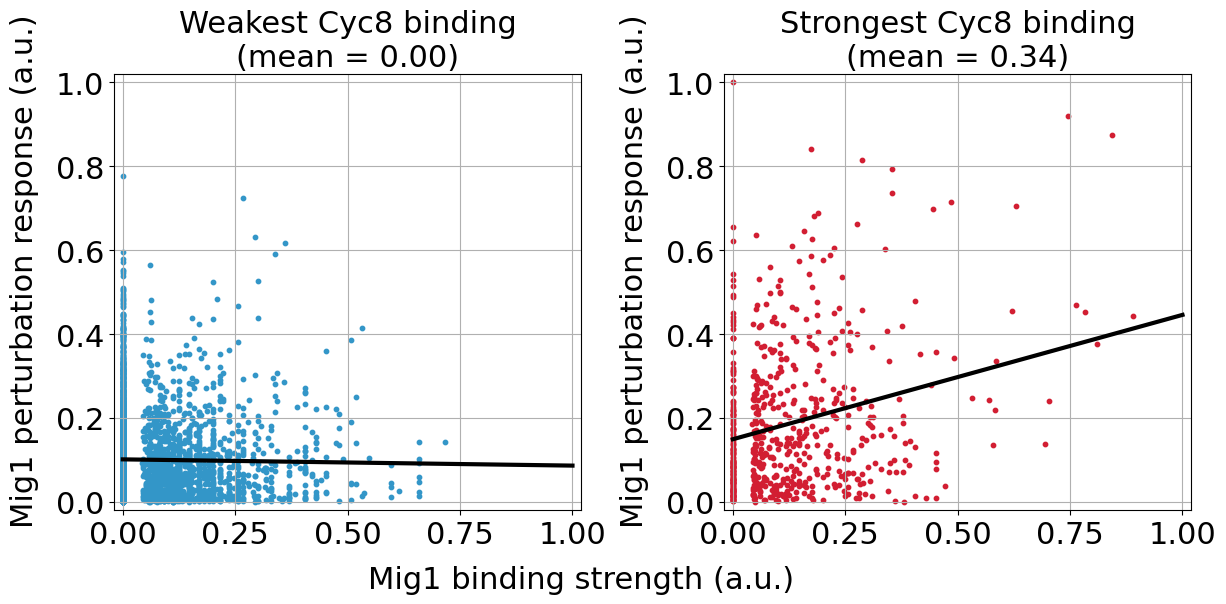

In [54]:
plot_dict.get(0.10).get("MIG1").get("CYC8")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

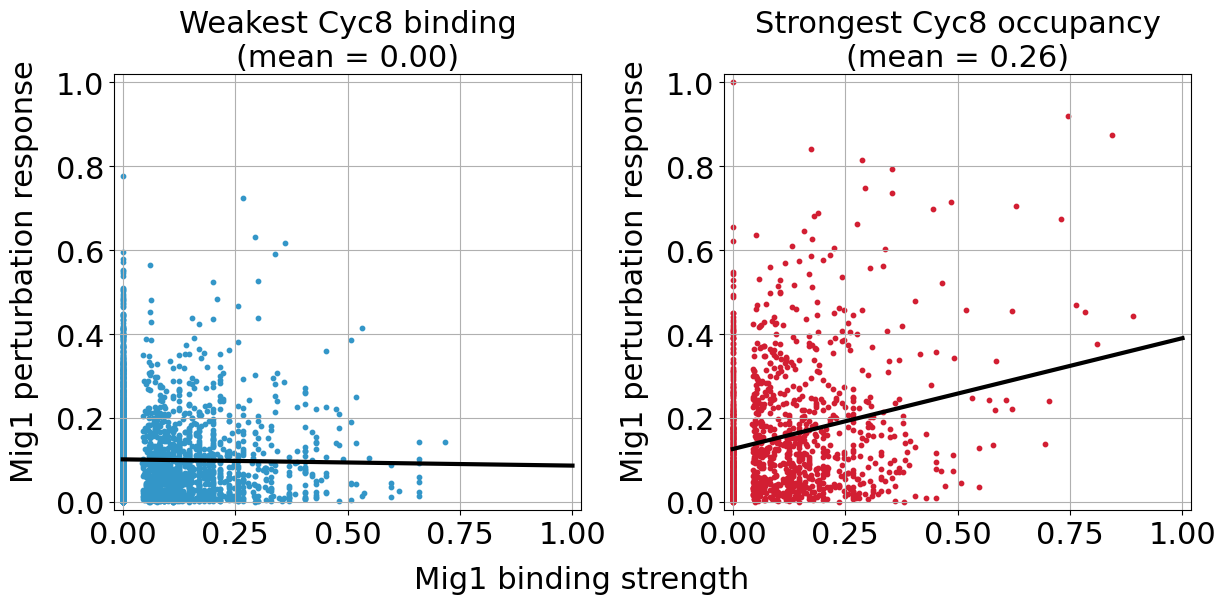

In [46]:

plot_dict.get(0.20).get("MIG1").get("CYC8")

In [55]:
import os

output_dir = "results/pTF_by_mTF_plots"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

for quantile_threshold, quantile_result in plot_dict.items():
    if quantile_threshold == 0.90:
        continue
    output_subdir = os.path.join(output_dir, "percentile_" + str(int(quantile_threshold * 100)))
    os.makedirs(output_subdir, exist_ok=True)
    for pTF, mTF_dict in quantile_result.items():
        for mTF, fig in mTF_dict.items():
            filename = f"{pTF}_{mTF}.pdf"
            filepath = os.path.join(output_subdir, filename)
            fig.savefig(filepath, bbox_inches='tight')


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

In [ ]:

x = plot_linear_fits(predictors_df,
                 response_frames_dict.get(pTF).set_index("target_symbol"),
                 chisquared_res.get(pTF).get(f"{pTF}:{mTF}")["mtf_low_index"],
                 chisquared_res.get(pTF).get(f"{pTF}:{mTF}")["mtf_high_index"], mTF, pTF)

In [71]:
from tabulate import tabulate

def print_chi_squared_results(model, chisquared_res):

    for i, (interactor, result) in enumerate(chisquared_res[model].items()):
        if i > 0:
            print("\n")

        print(f"Model: {model} - Interator: {interactor}")
        print(f"Chi² Stat: {result['chi2_stat']:.2f}")
        print(f"P-value: {result['pvalue']:.3g}")
        print(f"Degrees of Freedom: {result['dof']}")
        print(f"Main effect comparison: {result['main_effect_compare']}")
        print(f"Observed > Expected: {result['Low_mTF_High_pTF_observed_gt_expected']}")
        print(f"pTF by low mTF slope: {result['ptf_by_low_mtf_slope']:.2f}")
        print(f"pTF by high mTF slope: {result['ptf_by_high_mtf_slope']:.2f}")
        print("Expected Frequencies:")
        print(tabulate(result['expected_freq'],
                       headers=["oTF Low", "oTF High"],
                       showindex=["pTF Low", "pTF High"],
                       tablefmt="grid"))
        print("Observed Contingency Table:")
        print(tabulate(result['raw_table'],
                       headers=["oTF Low", "oTF High"],
                       showindex=["pTF Low", "pTF High"],
                       tablefmt='grid'))

print_chi_squared_results("ACE2", chisquared_res.get(0.10))

Model: ACE2 - Interator: ACE2:PGD1
Chi² Stat: 101.59
P-value: 6.82e-24
Degrees of Freedom: 1
Main effect comparison: NA
Observed > Expected: False
pTF by low mTF slope: 0.02
pTF by high mTF slope: 0.14
Expected Frequencies:
+----------+-----------+------------+
|          |   oTF Low |   oTF High |
+==========+===========+============+
| pTF Low  | 3922.55   |  608.449   |
+----------+-----------+------------+
| pTF High |   16.4486 |    2.55143 |
+----------+-----------+------------+
Observed Contingency Table:
+----------+-----------+------------+
|          |   oTF Low |   oTF High |
+==========+===========+============+
| pTF Low  |      3938 |        593 |
+----------+-----------+------------+
| pTF High |         1 |         18 |
+----------+-----------+------------+


Model: ACE2 - Interator: ACE2:GAL4
Chi² Stat: 0.00
P-value: 1
Degrees of Freedom: 1
Main effect comparison: NA
Observed > Expected: False
pTF by low mTF slope: 0.10
pTF by high mTF slope: 0.16
Expected Frequencies:

In [51]:
def extract_results_list(chisquared_quantile_res):
    chisquare_test_dist_list = []

    for key, value in chisquared_quantile_res.items():

        for interactor_term, chisq_res in value.items():
            output = {}
            output["model"] = key
            output['interactor'] = interactor_term.split(":")[1]
            output['chi2_stat'] = chisq_res["chi2_stat"]
            output['main_effect_comp'] = chisq_res["main_effect_compare"]
            output['Low_mTF_High_pTF_observed_gt_expected'] = chisq_res["Low_mTF_High_pTF_observed_gt_expected"]
            output['ptf_by_low_mtf_slope'] = chisq_res["ptf_by_low_mtf_slope"]
            output['ptf_by_high_mtf_slope'] = chisq_res["ptf_by_high_mtf_slope"]
            output['low_mTF_total'] = chisq_res['raw_table'].sum(axis=0)[0]
            output['high_mTF_total'] = chisq_res['raw_table'].sum(axis=0)[1]
            chisquare_test_dist_list.append(output)

    return chisquare_test_dist_list


In [52]:
for quantile_threshold, results_dict in chisquared_res.items():
    if quantile_threshold == 0.90:
        continue
    res_list = extract_results_list(results_dict)

    df = pd.DataFrame(res_list).sort_values(by="chi2_stat", ascending=False)
    percentile = str(int(quantile_threshold*100))
    df.to_csv(f"results/chisq_interaction_terms_{percentile}.csv", index=False)

df

model interactor  chi2_stat     main_effect_comp  \
15   GAL4       PGD1  82.279820                   NA   
67   ZAP1       PGD1  78.799629                   NA   
34   MSN2       PGD1  75.597018                   NA   
0    ACE2       PGD1  58.115218                   NA   
10   CIN5       GAT4  57.662549                   NA   
..    ...        ...        ...                  ...   
1    ACE2       GAL4   6.184098                   NA   
44   PDR3       GAL4   4.248763                   NA   
9    CBF1       GAL4   3.933410                   NA   
30  MET31       GAL4   2.104154  main effect greater   
31  MET32       GAL4   1.412355                   NA   

    Low_mTF_High_pTF_observed_gt_expected  ptf_by_low_mtf_slope  \
15                                  False             -0.069663   
67                                  False             -0.031005   
34                                  False              0.039977   
0                                   False              0.016595   
10                                  False              0.003091   
..                                    ...                   ...   
1                                   False              0.097704   
44                                  False              0.050296   
9                                   False              0.102505   
30                                  False             -0.031768   
31                                  False              0.011165   

    ptf_by_high_mtf_slope  low_mTF_total  high_mTF_total  
15               0.146449           3939            1241  
67               0.065880           3939            1241  
34               0.356053           3939            1241  
0                0.177103           3939            1241  
10               0.164587           3016            1294  
..                    ...            ...             ...  
1                0.161040           4746            1219  
44               0.163927           4746            1219  
9                0.191772           4746            1219  
30               0.082385           4746            1219  
31               0.112664           4746            1219  

[68 rows x 9 columns]

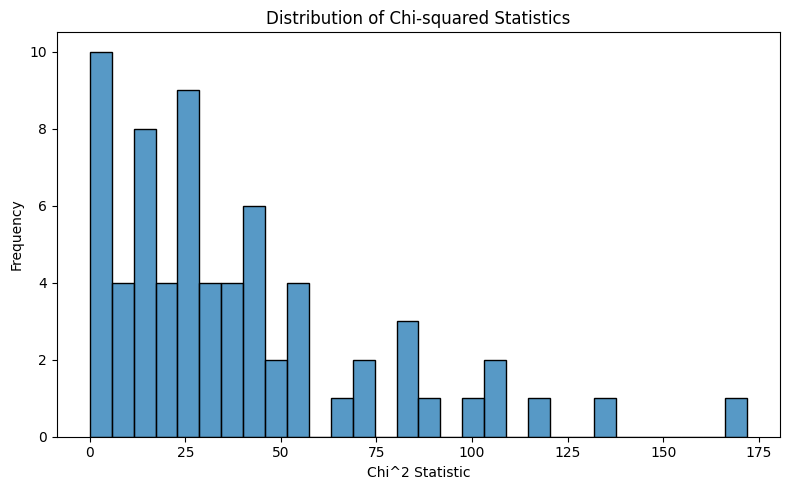

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(df["chi2_stat"], bins=30)
plt.title("Distribution of Chi-squared Statistics")
plt.xlabel("Chi^2 Statistic")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [113]:
chisquared_res.get("GAL4")

{'GAL4:PGD1': {'chi2_stat': 171.95323450228452,
  'pvalue': 2.7706042460234492e-39,
  'dof': 1,
  'expected_freq': array([[3911.29714286,  606.70285714],
         [  27.70285714,    4.29714286]]),
  'raw_table': mTF_bin  Bottom  Top
  pTF_bin             
  Low        3937  581
  High          2   30}}

In [104]:
from scipy.optimize import show_options
from scipy.optimize import show_options

show_options(solver="minimize", method = "L-BFGS-B")

Minimize a scalar function of one or more variables using the L-BFGS-B
algorithm.

Options
-------
disp : None or int
    If `disp is None` (the default), then the supplied version of `iprint`
    is used. If `disp is not None`, then it overrides the supplied version
    of `iprint` with the behaviour you outlined.
maxcor : int
    The maximum number of variable metric corrections used to
    define the limited memory matrix. (The limited memory BFGS
    method does not store the full hessian but uses this many terms
    in an approximation to it.)
ftol : float
    The iteration stops when ``(f^k -
    f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol``.
gtol : float
    The iteration will stop when ``max{|proj g_i | i = 1, ..., n}
    <= gtol`` where ``proj g_i`` is the i-th component of the
    projected gradient.
eps : float or ndarray
    If `jac is None` the absolute step size used for numerical
    approximation of the jacobian via forward differences.
maxfun : int
    Maximum number of fu

In [105]:
from scipy.optimize import minimize, _minimize_lbfgsb

ImportError: cannot import name '_minimize_lbfgsb' from 'scipy.optimize' (/home/chase/code/yeastdnnexplorer/.venv/lib/python3.11/site-packages/scipy/optimize/__init__.py)

In [2]:
from yeastdnnexplorer.ml_models.lasso_modeling import BootstrapModelResults

bms = BootstrapModelResults.from_jsonl("/home/chase/htcf_local/testing_sigmoid/testing_sigmoid_minimizer_options/ROX1")

In [5]:
bms.alpha_df

bootstrap_idx      alpha  fold       mse
0               1   0.000100     0  0.213915
1               1   0.000100     1  0.166818
2               1   0.000100     2  0.206807
3               1   0.000100     3  0.180730
4               1   2.500075     0  0.213328
5               1   2.500075     1  0.165064
6               1   2.500075     2  0.196636
7               1   2.500075     3  0.182336
8               1   5.000050     0  0.213328
9               1   5.000050     1  0.165064
10              1   5.000050     2  0.196636
11              1   5.000050     3  0.182336
12              1   7.500025     0  0.213328
13              1   7.500025     1  0.165064
14              1   7.500025     2  0.196636
15              1   7.500025     3  0.182336
16              1  10.000000     0  0.213328
17              1  10.000000     1  0.165064
18              1  10.000000     2  0.196636
19              1  10.000000     3  0.182336
20              2   0.000100     0  0.209655
21              2   0.000100     1  0.203720
22              2   0.000100     2  0.193772
23              2   0.000100     3  0.187546
24              2   2.500075     0  0.202046
25              2   2.500075     1  0.197957
26              2   2.500075     2  0.191889
27              2   2.500075     3  0.182718
28              2   5.000050     0  0.202046
29              2   5.000050     1  0.197957
30              2   5.000050     2  0.191889
31              2   5.000050     3  0.182718
32              2   7.500025     0  0.202046
33              2   7.500025     1  0.197957
34              2   7.500025     2  0.191889
35              2   7.500025     3  0.182718
36              2  10.000000     0  0.202046
37              2  10.000000     1  0.197957
38              2  10.000000     2  0.191889
39              2  10.000000     3  0.182718
40              3   0.000100     0  0.176476
41              3   0.000100     1  0.198103
42              3   0.000100     2  0.188532
43              3   0.000100     3  0.187822
44              3   2.500075     0  0.181023
45              3   2.500075     1  0.199903
46              3   2.500075     2  0.194781
47              3   2.500075     3  0.192766
48              3   5.000050     0  0.181023
49              3   5.000050     1  0.199903
50              3   5.000050     2  0.194781
51              3   5.000050     3  0.192766
52              3   7.500025     0  0.181023
53              3   7.500025     1  0.199903
54              3   7.500025     2  0.194781
55              3   7.500025     3  0.192766
56              3  10.000000     0  0.181023
57              3  10.000000     1  0.199903
58              3  10.000000     2  0.194781
59              3  10.000000     3  0.192766

In [6]:
bms.bootstrap_coefs_df

bootstrap_idx     alpha  ...  ROX1:CSE2  ROX1:LEU3
0              1  2.500075  ...   0.000000   0.000000
1              2  2.500075  ...   0.000000   0.000000
2              3  0.000100  ...  -0.681929   0.069474

[3 rows x 126 columns]

In [ ]:
import os

results_dir = "/home/chase/htcf_local/testing_sigmoid/testing_sigmoid_minimizer_options"

# create a list of the subdirectories
regulator_subdirs = [
    os.path.join(results_dir, d)
    for d in os.listdir(results_dir)
    if os.path.isdir(os.path.join(results_dir, d))
]

bms_results_dict = {os.path.basename(subdir): BootstrapModelResults.from_jsonl(subdir)
                    for subdir in regulator_subdirs}



NameError: name 'results_path' is not defined

In [13]:
bms_results_dict.get("ROX1").alpha_df

bootstrap_idx      alpha  fold       mse
0               1   0.000100     0  0.213915
1               1   0.000100     1  0.166818
2               1   0.000100     2  0.206807
3               1   0.000100     3  0.180730
4               1   2.500075     0  0.213328
5               1   2.500075     1  0.165064
6               1   2.500075     2  0.196636
7               1   2.500075     3  0.182336
8               1   5.000050     0  0.213328
9               1   5.000050     1  0.165064
10              1   5.000050     2  0.196636
11              1   5.000050     3  0.182336
12              1   7.500025     0  0.213328
13              1   7.500025     1  0.165064
14              1   7.500025     2  0.196636
15              1   7.500025     3  0.182336
16              1  10.000000     0  0.213328
17              1  10.000000     1  0.165064
18              1  10.000000     2  0.196636
19              1  10.000000     3  0.182336
20              2   0.000100     0  0.209655
21              2   0.000100     1  0.203720
22              2   0.000100     2  0.193772
23              2   0.000100     3  0.187546
24              2   2.500075     0  0.202046
25              2   2.500075     1  0.197957
26              2   2.500075     2  0.191889
27              2   2.500075     3  0.182718
28              2   5.000050     0  0.202046
29              2   5.000050     1  0.197957
30              2   5.000050     2  0.191889
31              2   5.000050     3  0.182718
32              2   7.500025     0  0.202046
33              2   7.500025     1  0.197957
34              2   7.500025     2  0.191889
35              2   7.500025     3  0.182718
36              2  10.000000     0  0.202046
37              2  10.000000     1  0.197957
38              2  10.000000     2  0.191889
39              2  10.000000     3  0.182718
40              3   0.000100     0  0.176476
41              3   0.000100     1  0.198103
42              3   0.000100     2  0.188532
43              3   0.000100     3  0.187822
44              3   2.500075     0  0.181023
45              3   2.500075     1  0.199903
46              3   2.500075     2  0.194781
47              3   2.500075     3  0.192766
48              3   5.000050     0  0.181023
49              3   5.000050     1  0.199903
50              3   5.000050     2  0.194781
51              3   5.000050     3  0.192766
52              3   7.500025     0  0.181023
53              3   7.500025     1  0.199903
54              3   7.500025     2  0.194781
55              3   7.500025     3  0.192766
56              3  10.000000     0  0.181023
57              3  10.000000     1  0.199903
58              3  10.000000     2  0.194781
59              3  10.000000     3  0.192766